In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim

from tensorflow.contrib.layers import *
%matplotlib inline

In [2]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

# Modules

In [3]:
# Discriminator
def D(x,h_dim=256,reuse=False):
    
    with tf.variable_scope('D',reuse=reuse):
        
        fc1 = fully_connected(inputs=x,  num_outputs=h_dim,activation_fn=tf.nn.relu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.relu)
        fc3 = fully_connected(inputs=fc2,num_outputs=h_dim,activation_fn=tf.nn.relu)
        logits = fully_connected(inputs=fc3,num_outputs=1, activation_fn=None)
        out = tf.sigmoid(logits)
        
        return out, logits


# generator
def G(z, is_training,h_dim=128, reuse=False):
    
    with tf.variable_scope('G',reuse=reuse):
        
#         with slim.arg_scope([slim.conv2d, slim.fully_connected],
#                     activation_fn=tf.nn.leaky_relu,
#                     normalizer_fn=tf.layers.batch_normalization,
#                     normalizer_params={'training': is_training, 'momentum': 0.95}):


        fc1 = fully_connected(inputs=z,  num_outputs=h_dim,activation_fn=tf.nn.leaky_relu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.leaky_relu)
        out = fully_connected(inputs=fc2,num_outputs=2, activation_fn=tf.nn.tanh)

        return out


# Statistics network for MINE
def M(inp,h_dim=128, reuse=False):
    
    with tf.variable_scope('M',reuse=reuse):
        
        fc1 = fully_connected(inputs=inp,num_outputs=h_dim,activation_fn=tf.nn.elu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.elu)
        fc3 = fully_connected(inputs=fc2,num_outputs=h_dim,activation_fn=tf.nn.elu)
        out = fully_connected(inputs=fc3,num_outputs=1, activation_fn=None)
    
        return out

# computational graph

In [4]:
noise_dim = 6
code_dim  = 4

tf.reset_default_graph()

x_real = tf.placeholder(tf.float32,shape=[None,2],name='x_real')
eps    = tf.placeholder(tf.float32,shape=[None,noise_dim],name='eps')
code   = tf.placeholder(tf.float32,shape=[None,code_dim],name='code')
is_training = tf.placeholder(tf.bool,shape=[],name='is_training')

# generator
z = tf.concat([eps,code], axis=1)
x_tld = G(z, is_training)

# discriminator
D_out_real, D_log_real = D(x_real)
D_out_fake, D_log_fake = D(x_tld,reuse=True)


# mine
c_bar = tf.random_shuffle(code)

joint = tf.concat([code,x_tld], axis=1)
margn = tf.concat([c_bar,x_tld], axis=1)

t  = M(joint)
et = tf.exp(M(margn,reuse=True))



In [5]:
# print variables in graph
l = [x.name for x in tf.global_variables()]

for ll in l:
    print(ll)

G/fully_connected/weights:0
G/fully_connected/biases:0
G/fully_connected_1/weights:0
G/fully_connected_1/biases:0
G/fully_connected_2/weights:0
G/fully_connected_2/biases:0
D/fully_connected/weights:0
D/fully_connected/biases:0
D/fully_connected_1/weights:0
D/fully_connected_1/biases:0
D/fully_connected_2/weights:0
D/fully_connected_2/biases:0
D/fully_connected_3/weights:0
D/fully_connected_3/biases:0
M/fully_connected/weights:0
M/fully_connected/biases:0
M/fully_connected_1/weights:0
M/fully_connected_1/biases:0
M/fully_connected_2/weights:0
M/fully_connected_2/biases:0
M/fully_connected_3/weights:0
M/fully_connected_3/biases:0


# loss function

In [6]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

# ----- D ----- #
D_real_loss=loss_func(D_log_real,tf.ones_like(D_log_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_log_fake,tf.zeros_like(D_log_real))
D_loss = D_real_loss + D_fake_loss

# ----- M ----- #
M_loss = -(tf.reduce_mean(t) - tf.log(tf.reduce_mean(et)))

# ----- G ----- #
G_loss = loss_func(D_log_fake,tf.ones_like(D_log_fake)) + M_loss




# optimizers

In [7]:
lr = 1e-4


tvars=tf.trainable_variables() 

d_vars=[var for var in tvars if 'D' in var.name]
g_vars=[var for var in tvars if 'G' in var.name]
m_vars=[var for var in tvars if 'M' in var.name]

D_train_op=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
# M_train_op_m=tf.train.AdamOptimizer(lr).minimize(M_loss,var_list=m_vars)
# M_optimizer = tf.train.AdamOptimizer(lr)
G_train_op=tf.train.AdamOptimizer(lr).minimize(G_loss,var_list=g_vars)
M_train_op=tf.train.AdamOptimizer(lr).minimize(M_loss,var_list=m_vars)

In [8]:
batch_size=256
epochs=100


# Gradient clipping

In [9]:
ggu = tf.gradients(G_loss, g_vars)
ggm = tf.gradients(M_loss, g_vars)

# Make toy data

In [10]:
x = 0.2 * np.random.randn(20000, 2)

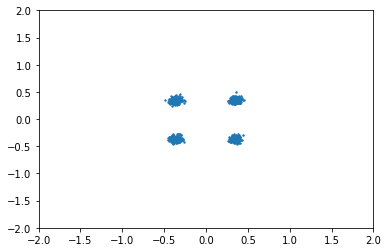

In [11]:
x = np.array([(i,j) for i in range(-4, 5, 6) for j in range(-4, 5, 6)] * 5000)
x = x + 0.3 * np.random.randn(*x.shape)

x = (x - np.amin(x))/(np.amax(x) - np.amin(x)) - 0.5

# shuffle
np.random.shuffle(x)
plt.scatter(x[:1000,0], x[:1000,1], s=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.show()

In [12]:
n_samples = x.shape[0]
num_batches = n_samples//batch_size

ep:0, D_real_loss: 0.6677, D_fake_loss: 0.6601, D_out_fk: 0.4817,D_out_rl: 0.5193, G_loss: 0.6967, M_loss: 0.0365
g1:-0.0001441907079424709, g2:-4.340553641668521e-05


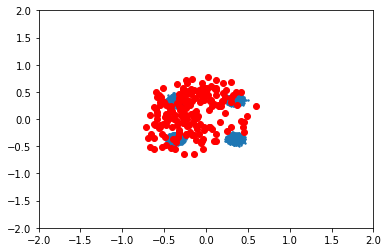

ep:1, D_real_loss: 0.8147, D_fake_loss: 0.5182, D_out_fk: 0.3978,D_out_rl: 0.4371, G_loss: 0.5866, M_loss: 0.3607
g1:0.00010311442019883543, g2:-0.0002457754744682461
ep:2, D_real_loss: 0.7502, D_fake_loss: 0.4601, D_out_fk: 0.3635,D_out_rl: 0.4781, G_loss: 0.2092, M_loss: 0.8290
g1:6.01470164838247e-05, g2:-0.00033309200080111623
ep:3, D_real_loss: 0.7734, D_fake_loss: 0.4967, D_out_fk: 0.3834,D_out_rl: 0.4582, G_loss: -0.2348, M_loss: 1.2216
g1:0.00029678220744244754, g2:-0.0004630872863344848
ep:4, D_real_loss: 0.7691, D_fake_loss: 0.6219, D_out_fk: 0.4623,D_out_rl: 0.4563, G_loss: -0.5762, M_loss: 1.3497
g1:0.0003069777740165591, g2:-0.000505496864207089
ep:5, D_real_loss: 0.7985, D_fake_loss: 0.5775, D_out_fk: 0.4385,D_out_rl: 0.4394, G_loss: -0.5653, M_loss: 1.3901
g1:0.00020687610958702862, g2:-0.0002356146724196151
ep:6, D_real_loss: 0.7704, D_fake_loss: 0.6170, D_out_fk: 0.4603,D_out_rl: 0.4547, G_loss: -0.4930, M_loss: 1.2692
g1:-3.1081213819561526e-05, g2:-0.0003388237382750

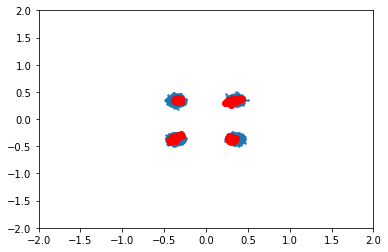

ep:11, D_real_loss: 0.7824, D_fake_loss: 0.5932, D_out_fk: 0.4472,D_out_rl: 0.4481, G_loss: -0.4876, M_loss: 1.2929
g1:0.00011982055730186403, g2:-1.4129083865555003e-05
ep:12, D_real_loss: 0.7649, D_fake_loss: 0.6152, D_out_fk: 0.4594,D_out_rl: 0.4575, G_loss: -0.5999, M_loss: 1.3777
g1:-8.283043280243874e-05, g2:-0.00013611282338388264
ep:13, D_real_loss: 0.7887, D_fake_loss: 0.5886, D_out_fk: 0.4446,D_out_rl: 0.4448, G_loss: -0.3993, M_loss: 1.2109
g1:0.0003455607802607119, g2:0.00028170651057735085
ep:14, D_real_loss: 0.7791, D_fake_loss: 0.5962, D_out_fk: 0.4487,D_out_rl: 0.4500, G_loss: -0.4656, M_loss: 1.2679
g1:-0.00012041173613397405, g2:-0.00020241673337295651
ep:15, D_real_loss: 0.7739, D_fake_loss: 0.6026, D_out_fk: 0.4525,D_out_rl: 0.4527, G_loss: -0.5712, M_loss: 1.3644
g1:0.00041692465310916305, g2:0.0003995184670202434
ep:16, D_real_loss: 0.7873, D_fake_loss: 0.5882, D_out_fk: 0.4446,D_out_rl: 0.4453, G_loss: -0.7612, M_loss: 1.5721
g1:-4.306063783587888e-05, g2:-0.0001

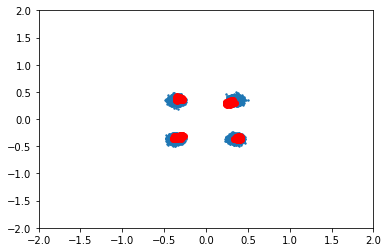

ep:21, D_real_loss: 0.7906, D_fake_loss: 0.5941, D_out_fk: 0.4478,D_out_rl: 0.4436, G_loss: -0.6220, M_loss: 1.4256
g1:-0.00022298241674434394, g2:-0.00017864006804302335
ep:22, D_real_loss: 0.7935, D_fake_loss: 0.5717, D_out_fk: 0.4350,D_out_rl: 0.4424, G_loss: -0.4713, M_loss: 1.3049
g1:0.0005280661280266941, g2:0.00027558254078030586
ep:23, D_real_loss: 0.7542, D_fake_loss: 0.6194, D_out_fk: 0.4615,D_out_rl: 0.4641, G_loss: -0.5564, M_loss: 1.3300
g1:-0.00034771152422763407, g2:-0.00038339741877280176
ep:24, D_real_loss: 0.7877, D_fake_loss: 0.5948, D_out_fk: 0.4479,D_out_rl: 0.4455, G_loss: -0.5952, M_loss: 1.3994
g1:-0.00028874841518700123, g2:-0.00028732570353895426
ep:25, D_real_loss: 0.7745, D_fake_loss: 0.5964, D_out_fk: 0.4490,D_out_rl: 0.4525, G_loss: -0.5528, M_loss: 1.3542
g1:-0.0003769535687752068, g2:-0.0004473455483093858
ep:26, D_real_loss: 0.7691, D_fake_loss: 0.6086, D_out_fk: 0.4559,D_out_rl: 0.4552, G_loss: -0.5277, M_loss: 1.3133
g1:-0.0006855103420093656, g2:-0.0

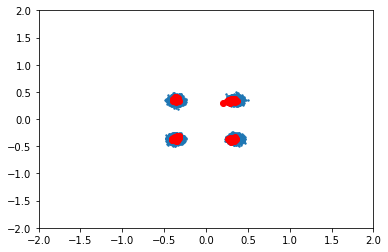

ep:31, D_real_loss: 0.7960, D_fake_loss: 0.5852, D_out_fk: 0.4430,D_out_rl: 0.4405, G_loss: -0.6397, M_loss: 1.4542
g1:0.0005888370214961469, g2:0.0006524703931063414
ep:32, D_real_loss: 0.7834, D_fake_loss: 0.5944, D_out_fk: 0.4481,D_out_rl: 0.4474, G_loss: -0.7008, M_loss: 1.5037
g1:-0.0002897588419727981, g2:-0.0004647495225071907
ep:33, D_real_loss: 0.7586, D_fake_loss: 0.6191, D_out_fk: 0.4615,D_out_rl: 0.4612, G_loss: -0.6285, M_loss: 1.4019
g1:-0.00021014007506892085, g2:-0.0001817991433199495
ep:34, D_real_loss: 0.7824, D_fake_loss: 0.5996, D_out_fk: 0.4509,D_out_rl: 0.4479, G_loss: -0.5316, M_loss: 1.3284
g1:-0.0004169419116806239, g2:-0.0003670128062367439
ep:35, D_real_loss: 0.7943, D_fake_loss: 0.5791, D_out_fk: 0.4396,D_out_rl: 0.4414, G_loss: -0.4890, M_loss: 1.3110
g1:-0.00018897531845141202, g2:-0.0003278454241808504
ep:36, D_real_loss: 0.7755, D_fake_loss: 0.6049, D_out_fk: 0.4538,D_out_rl: 0.4517, G_loss: -0.6759, M_loss: 1.4660
g1:4.9823036533780396e-05, g2:-0.000158

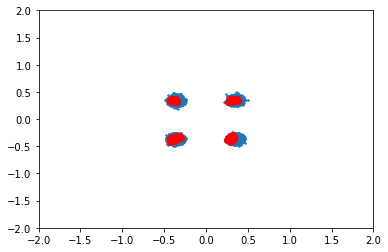

ep:41, D_real_loss: 0.7624, D_fake_loss: 0.6130, D_out_fk: 0.4582,D_out_rl: 0.4590, G_loss: -0.5456, M_loss: 1.3261
g1:-0.00012827572936657816, g2:-0.0001188509922940284
ep:42, D_real_loss: 0.7823, D_fake_loss: 0.5973, D_out_fk: 0.4496,D_out_rl: 0.4481, G_loss: -0.4132, M_loss: 1.2130
g1:-0.0009018012788146734, g2:-0.0008245791541412473
ep:43, D_real_loss: 0.7847, D_fake_loss: 0.5855, D_out_fk: 0.4430,D_out_rl: 0.4468, G_loss: -0.4868, M_loss: 1.3014
g1:0.000553394085727632, g2:0.0005496218800544739
ep:44, D_real_loss: 0.7771, D_fake_loss: 0.5964, D_out_fk: 0.4490,D_out_rl: 0.4510, G_loss: -0.6391, M_loss: 1.4405
g1:0.00043479661690071225, g2:0.00032215798273682594
ep:45, D_real_loss: 0.7695, D_fake_loss: 0.6023, D_out_fk: 0.4524,D_out_rl: 0.4550, G_loss: -0.6099, M_loss: 1.4032
g1:-0.000507766380906105, g2:-0.0005137175903655589
ep:46, D_real_loss: 0.7683, D_fake_loss: 0.6054, D_out_fk: 0.4540,D_out_rl: 0.4558, G_loss: -0.5872, M_loss: 1.3773
g1:-0.0002603748580440879, g2:-9.149992547

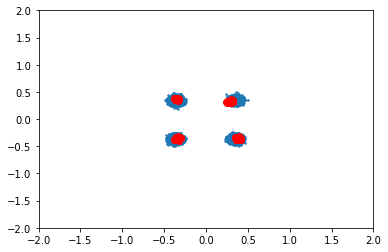

ep:51, D_real_loss: 0.7865, D_fake_loss: 0.5897, D_out_fk: 0.4454,D_out_rl: 0.4457, G_loss: -0.5657, M_loss: 1.3748
g1:0.0002972711808979511, g2:0.0003892062231898308
ep:52, D_real_loss: 0.7859, D_fake_loss: 0.5811, D_out_fk: 0.4406,D_out_rl: 0.4461, G_loss: -0.6103, M_loss: 1.4305
g1:0.00010255588858854026, g2:-0.00012431554205249995
ep:53, D_real_loss: 0.7653, D_fake_loss: 0.6117, D_out_fk: 0.4576,D_out_rl: 0.4573, G_loss: -0.5503, M_loss: 1.3322
g1:2.520562702557072e-06, g2:-7.294525858014822e-05
ep:54, D_real_loss: 0.7739, D_fake_loss: 0.6006, D_out_fk: 0.4514,D_out_rl: 0.4527, G_loss: -0.5146, M_loss: 1.3103
g1:0.00014574098167940974, g2:0.00021479110000655055
ep:55, D_real_loss: 0.7823, D_fake_loss: 0.5973, D_out_fk: 0.4496,D_out_rl: 0.4480, G_loss: -0.6395, M_loss: 1.4391
g1:-0.0004270633216947317, g2:-0.00029275414999574423
ep:56, D_real_loss: 0.8054, D_fake_loss: 0.5675, D_out_fk: 0.4327,D_out_rl: 0.4358, G_loss: -0.2930, M_loss: 1.1319
g1:-1.5905607142485678e-06, g2:-0.000109

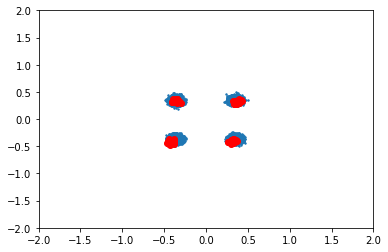

ep:61, D_real_loss: 0.7812, D_fake_loss: 0.5941, D_out_fk: 0.4478,D_out_rl: 0.4487, G_loss: -0.5695, M_loss: 1.3732
g1:-0.00028544693486765027, g2:-0.00040929124224931
ep:62, D_real_loss: 0.7768, D_fake_loss: 0.6015, D_out_fk: 0.4520,D_out_rl: 0.4509, G_loss: -0.4105, M_loss: 1.2047
g1:0.000218740533455275, g2:0.0001417882740497589
ep:63, D_real_loss: 0.7721, D_fake_loss: 0.6042, D_out_fk: 0.4535,D_out_rl: 0.4535, G_loss: -0.7185, M_loss: 1.5093
g1:-0.00015932768292259425, g2:-0.00010940202628262341
ep:64, D_real_loss: 0.7898, D_fake_loss: 0.5886, D_out_fk: 0.4449,D_out_rl: 0.4438, G_loss: -0.5670, M_loss: 1.3769
g1:0.00036624312633648515, g2:0.00041222351137548685
ep:65, D_real_loss: 0.7767, D_fake_loss: 0.6000, D_out_fk: 0.4511,D_out_rl: 0.4511, G_loss: -0.5383, M_loss: 1.3347
g1:-1.9380422600079328e-08, g2:-3.972121703554876e-05
ep:66, D_real_loss: 0.7717, D_fake_loss: 0.6065, D_out_fk: 0.4547,D_out_rl: 0.4538, G_loss: -0.7468, M_loss: 1.5349
g1:0.0002933093055617064, g2:0.000249810

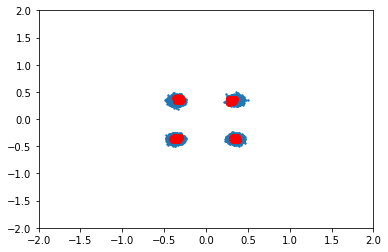

ep:71, D_real_loss: 0.7813, D_fake_loss: 0.5909, D_out_fk: 0.4458,D_out_rl: 0.4490, G_loss: -0.5340, M_loss: 1.3431
g1:0.0005898113595321774, g2:0.0005730199045501649
ep:72, D_real_loss: 0.7687, D_fake_loss: 0.6019, D_out_fk: 0.4520,D_out_rl: 0.4556, G_loss: -0.5478, M_loss: 1.3422
g1:-0.0003754434292204678, g2:-0.00036602711770683527
ep:73, D_real_loss: 0.7894, D_fake_loss: 0.5800, D_out_fk: 0.4400,D_out_rl: 0.4441, G_loss: -0.4686, M_loss: 1.2898
g1:6.268212018767372e-05, g2:5.282164420350455e-05
ep:74, D_real_loss: 0.7750, D_fake_loss: 0.5972, D_out_fk: 0.4495,D_out_rl: 0.4520, G_loss: -0.5370, M_loss: 1.3368
g1:0.0003401848371140659, g2:0.00031436842982657254
ep:75, D_real_loss: 0.7830, D_fake_loss: 0.5883, D_out_fk: 0.4447,D_out_rl: 0.4475, G_loss: -0.7784, M_loss: 1.5889
g1:0.00032653071684762836, g2:0.0003265178529545665
ep:76, D_real_loss: 0.7771, D_fake_loss: 0.5983, D_out_fk: 0.4503,D_out_rl: 0.4507, G_loss: -0.6665, M_loss: 1.4644
g1:0.00024808806483633816, g2:0.000237540400

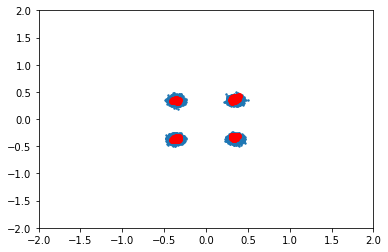

ep:81, D_real_loss: 0.7827, D_fake_loss: 0.5949, D_out_fk: 0.4483,D_out_rl: 0.4477, G_loss: -0.5505, M_loss: 1.3528
g1:0.00036649536923505366, g2:0.00031658337684348226
ep:82, D_real_loss: 0.7753, D_fake_loss: 0.5997, D_out_fk: 0.4509,D_out_rl: 0.4518, G_loss: -0.6597, M_loss: 1.4562
g1:-3.0214961952879094e-05, g2:-6.958692392800003e-05
ep:83, D_real_loss: 0.7780, D_fake_loss: 0.5955, D_out_fk: 0.4487,D_out_rl: 0.4503, G_loss: -0.4874, M_loss: 1.2889
g1:5.3044044761918485e-05, g2:4.115788033232093e-05
ep:84, D_real_loss: 0.7793, D_fake_loss: 0.5960, D_out_fk: 0.4490,D_out_rl: 0.4495, G_loss: -0.7769, M_loss: 1.5777
g1:0.0002311909629497677, g2:0.0002138908312190324
ep:85, D_real_loss: 0.7828, D_fake_loss: 0.5925, D_out_fk: 0.4471,D_out_rl: 0.4476, G_loss: -0.9003, M_loss: 1.7054
g1:2.229882375104353e-05, g2:-6.690030204481445e-06
ep:86, D_real_loss: 0.7818, D_fake_loss: 0.5942, D_out_fk: 0.4480,D_out_rl: 0.4481, G_loss: -0.8355, M_loss: 1.6384
g1:-0.00010266181197948754, g2:-0.00014618

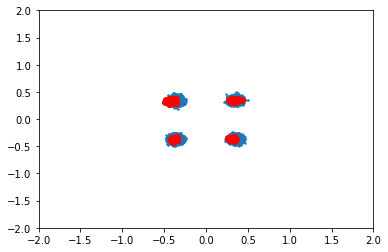

ep:91, D_real_loss: 0.7798, D_fake_loss: 0.5893, D_out_fk: 0.4449,D_out_rl: 0.4497, G_loss: -0.4434, M_loss: 1.2546
g1:0.0002022242551902309, g2:7.005914085311815e-05
ep:92, D_real_loss: 0.7787, D_fake_loss: 0.5917, D_out_fk: 0.4465,D_out_rl: 0.4501, G_loss: -0.6105, M_loss: 1.4171
g1:-0.00031383565510623157, g2:-0.00031907708034850657
ep:93, D_real_loss: 0.7763, D_fake_loss: 0.5947, D_out_fk: 0.4482,D_out_rl: 0.4513, G_loss: -0.6837, M_loss: 1.4864
g1:9.657474583946168e-05, g2:7.931034633656964e-05
ep:94, D_real_loss: 0.7819, D_fake_loss: 0.5872, D_out_fk: 0.4440,D_out_rl: 0.4483, G_loss: -0.6532, M_loss: 1.4654
g1:-0.00042831001337617636, g2:-0.00034800719004124403
ep:95, D_real_loss: 0.7714, D_fake_loss: 0.6003, D_out_fk: 0.4513,D_out_rl: 0.4539, G_loss: -0.4976, M_loss: 1.2933
g1:-0.00015817521489225328, g2:-0.00021846329036634415
ep:96, D_real_loss: 0.7831, D_fake_loss: 0.5872, D_out_fk: 0.4440,D_out_rl: 0.4476, G_loss: -0.4032, M_loss: 1.2154
g1:-0.00014317056047730148, g2:-0.000

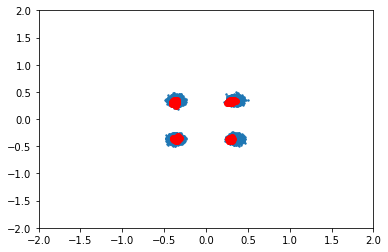

ep:101, D_real_loss: 0.7795, D_fake_loss: 0.5978, D_out_fk: 0.4500,D_out_rl: 0.4494, G_loss: -0.5342, M_loss: 1.3328
g1:0.00010052895231638104, g2:0.0001632204366615042
ep:102, D_real_loss: 0.7810, D_fake_loss: 0.5938, D_out_fk: 0.4478,D_out_rl: 0.4486, G_loss: -0.5458, M_loss: 1.3493
g1:0.0001262129080714658, g2:9.71869594650343e-05
ep:103, D_real_loss: 0.7754, D_fake_loss: 0.6021, D_out_fk: 0.4524,D_out_rl: 0.4517, G_loss: -0.5002, M_loss: 1.2935
g1:3.862501762341708e-05, g2:-6.0232436226215214e-05
ep:104, D_real_loss: 0.7783, D_fake_loss: 0.5964, D_out_fk: 0.4492,D_out_rl: 0.4501, G_loss: -0.5097, M_loss: 1.3102
g1:-0.0003441789885982871, g2:-0.00039659556932747364
ep:105, D_real_loss: 0.7724, D_fake_loss: 0.6013, D_out_fk: 0.4519,D_out_rl: 0.4534, G_loss: -0.6925, M_loss: 1.4869
g1:2.832162681443151e-05, g2:3.3542048186063766e-05
ep:106, D_real_loss: 0.7810, D_fake_loss: 0.5974, D_out_fk: 0.4497,D_out_rl: 0.4487, G_loss: -0.6794, M_loss: 1.4789
g1:-0.0002863944391719997, g2:-0.0001

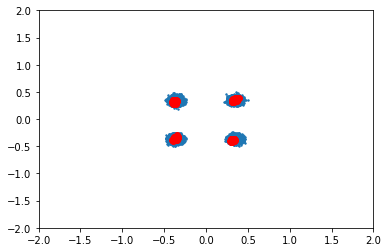

ep:111, D_real_loss: 0.7794, D_fake_loss: 0.5934, D_out_fk: 0.4474,D_out_rl: 0.4498, G_loss: -0.5252, M_loss: 1.3301
g1:0.00025400664890185, g2:0.00020413170568645
ep:112, D_real_loss: 0.7788, D_fake_loss: 0.5948, D_out_fk: 0.4482,D_out_rl: 0.4501, G_loss: -0.5562, M_loss: 1.3593
g1:-3.1783860322320834e-05, g2:-5.631743260892108e-05
ep:113, D_real_loss: 0.7792, D_fake_loss: 0.5924, D_out_fk: 0.4469,D_out_rl: 0.4498, G_loss: -0.4031, M_loss: 1.2091
g1:-0.00018977811851073056, g2:-0.00018637825269252062
ep:114, D_real_loss: 0.7748, D_fake_loss: 0.5987, D_out_fk: 0.4505,D_out_rl: 0.4520, G_loss: -0.6033, M_loss: 1.4008
g1:0.0008049455936998129, g2:0.0008028749143704772
ep:115, D_real_loss: 0.7785, D_fake_loss: 0.5964, D_out_fk: 0.4491,D_out_rl: 0.4500, G_loss: -0.5034, M_loss: 1.3040
g1:-7.972488674568012e-05, g2:-0.00010601313260849565
ep:116, D_real_loss: 0.7713, D_fake_loss: 0.5998, D_out_fk: 0.4510,D_out_rl: 0.4540, G_loss: -0.7590, M_loss: 1.5553
g1:9.65818835538812e-05, g2:5.8089044

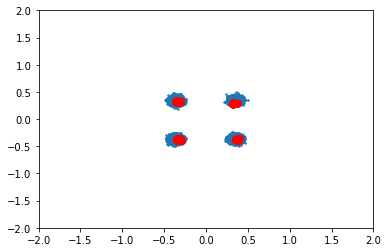

ep:121, D_real_loss: 0.7803, D_fake_loss: 0.5960, D_out_fk: 0.4489,D_out_rl: 0.4492, G_loss: -0.4388, M_loss: 1.2398
g1:-0.00031184087856672704, g2:-0.0002486796583980322
ep:122, D_real_loss: 0.7821, D_fake_loss: 0.5966, D_out_fk: 0.4491,D_out_rl: 0.4483, G_loss: -0.8593, M_loss: 1.6602
g1:-0.0002125183236785233, g2:-0.00016567489365115762
ep:123, D_real_loss: 0.7761, D_fake_loss: 0.5856, D_out_fk: 0.4430,D_out_rl: 0.4516, G_loss: -0.6495, M_loss: 1.4643
g1:9.18819714570418e-05, g2:-6.762074917787686e-06
ep:124, D_real_loss: 0.7748, D_fake_loss: 0.6044, D_out_fk: 0.4535,D_out_rl: 0.4522, G_loss: -0.6476, M_loss: 1.4386
g1:0.00021142834157217294, g2:0.00018924509640783072
ep:125, D_real_loss: 0.7794, D_fake_loss: 0.5971, D_out_fk: 0.4496,D_out_rl: 0.4495, G_loss: -0.7897, M_loss: 1.5893
g1:0.0002801413065753877, g2:0.0003165084053762257
ep:126, D_real_loss: 0.7811, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4486, G_loss: -0.6055, M_loss: 1.4057
g1:-7.074182212818414e-05, g2:-5.43

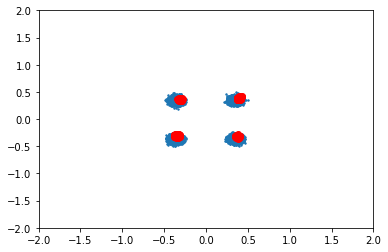

ep:131, D_real_loss: 0.7826, D_fake_loss: 0.5878, D_out_fk: 0.4443,D_out_rl: 0.4480, G_loss: -0.6471, M_loss: 1.4587
g1:-0.00029061175882816315, g2:-0.00012744053674396127
ep:132, D_real_loss: 0.7706, D_fake_loss: 0.5820, D_out_fk: 0.4406,D_out_rl: 0.4547, G_loss: -0.5318, M_loss: 1.3535
g1:0.0004538641369435936, g2:0.00021417398238554597
ep:133, D_real_loss: 0.7784, D_fake_loss: 0.5976, D_out_fk: 0.4497,D_out_rl: 0.4502, G_loss: -0.6783, M_loss: 1.4777
g1:-0.00010706323519116268, g2:-0.000216057087527588
ep:134, D_real_loss: 0.7766, D_fake_loss: 0.5971, D_out_fk: 0.4495,D_out_rl: 0.4512, G_loss: -0.4907, M_loss: 1.2903
g1:-0.0001697584957582876, g2:-5.581200821325183e-05
ep:135, D_real_loss: 0.7847, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4467, G_loss: -0.7846, M_loss: 1.5848
g1:-0.000236277817748487, g2:-0.0001826406514737755
ep:136, D_real_loss: 0.7766, D_fake_loss: 0.6008, D_out_fk: 0.4515,D_out_rl: 0.4512, G_loss: -0.5790, M_loss: 1.3744
g1:-0.00010197867231909186, g2:-0

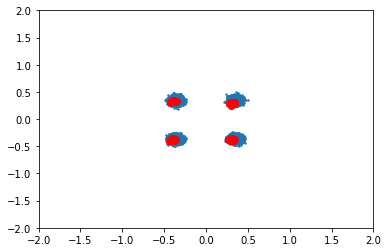

ep:141, D_real_loss: 0.7764, D_fake_loss: 0.6002, D_out_fk: 0.4512,D_out_rl: 0.4512, G_loss: -0.8640, M_loss: 1.6600
g1:-0.0002572739031165838, g2:-0.00023602826695423573
ep:142, D_real_loss: 0.7796, D_fake_loss: 0.5947, D_out_fk: 0.4482,D_out_rl: 0.4494, G_loss: -0.5755, M_loss: 1.3780
g1:-0.00038418371696025133, g2:-0.0003944701747968793
ep:143, D_real_loss: 0.7776, D_fake_loss: 0.5956, D_out_fk: 0.4488,D_out_rl: 0.4505, G_loss: -0.6968, M_loss: 1.4981
g1:-8.154662646120414e-05, g2:-0.00013303238665685058
ep:144, D_real_loss: 0.7827, D_fake_loss: 0.5945, D_out_fk: 0.4481,D_out_rl: 0.4478, G_loss: -0.4920, M_loss: 1.2948
g1:-8.021691610338166e-05, g2:-0.00013509618293028325
ep:145, D_real_loss: 0.7749, D_fake_loss: 0.5934, D_out_fk: 0.4475,D_out_rl: 0.4521, G_loss: -0.4841, M_loss: 1.2885
g1:0.00014616662519983947, g2:0.0001028793485602364
ep:146, D_real_loss: 0.7785, D_fake_loss: 0.5921, D_out_fk: 0.4466,D_out_rl: 0.4503, G_loss: -0.5037, M_loss: 1.3104
g1:-0.00011096968228230253, g2

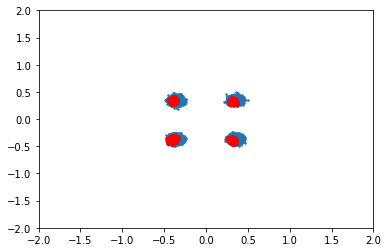

ep:151, D_real_loss: 0.7771, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4509, G_loss: -0.4938, M_loss: 1.2942
g1:-0.00032290889066644013, g2:-0.000407458923291415
ep:152, D_real_loss: 0.7825, D_fake_loss: 0.5969, D_out_fk: 0.4494,D_out_rl: 0.4479, G_loss: -0.5828, M_loss: 1.3828
g1:-0.00035437208134680986, g2:-0.00028347637271508574
ep:153, D_real_loss: 0.7764, D_fake_loss: 0.5940, D_out_fk: 0.4477,D_out_rl: 0.4514, G_loss: -0.7328, M_loss: 1.5368
g1:0.00010336196282878518, g2:5.850613524671644e-05
ep:154, D_real_loss: 0.7769, D_fake_loss: 0.6006, D_out_fk: 0.4512,D_out_rl: 0.4513, G_loss: -0.4179, M_loss: 1.2147
g1:-0.00044514049659483135, g2:-0.0003794383956119418
ep:155, D_real_loss: 0.7790, D_fake_loss: 0.5952, D_out_fk: 0.4482,D_out_rl: 0.4501, G_loss: -0.3420, M_loss: 1.1457
g1:0.00040357137913815677, g2:0.0003515450225677341
ep:156, D_real_loss: 0.7802, D_fake_loss: 0.6027, D_out_fk: 0.4526,D_out_rl: 0.4492, G_loss: -0.5886, M_loss: 1.3815
g1:2.9782882847939618e-05, g2:-7

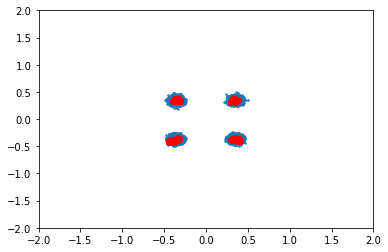

ep:161, D_real_loss: 0.7768, D_fake_loss: 0.5976, D_out_fk: 0.4498,D_out_rl: 0.4510, G_loss: -0.4499, M_loss: 1.2489
g1:5.442951078293845e-06, g2:-4.520369111560285e-05
ep:162, D_real_loss: 0.7785, D_fake_loss: 0.5946, D_out_fk: 0.4482,D_out_rl: 0.4500, G_loss: -0.4150, M_loss: 1.2175
g1:0.00028078106697648764, g2:0.0003707017458509654
ep:163, D_real_loss: 0.7780, D_fake_loss: 0.5977, D_out_fk: 0.4499,D_out_rl: 0.4503, G_loss: -0.6179, M_loss: 1.4167
g1:0.0005037154769524932, g2:0.00037910998798906803
ep:164, D_real_loss: 0.7735, D_fake_loss: 0.5915, D_out_fk: 0.4464,D_out_rl: 0.4530, G_loss: -0.4916, M_loss: 1.2984
g1:-1.4587481018679682e-05, g2:6.945012864889577e-05
ep:165, D_real_loss: 0.7726, D_fake_loss: 0.5910, D_out_fk: 0.4458,D_out_rl: 0.4538, G_loss: -0.4353, M_loss: 1.2441
g1:0.00032498768996447325, g2:8.067787712207064e-05
ep:166, D_real_loss: 0.7728, D_fake_loss: 0.5954, D_out_fk: 0.4479,D_out_rl: 0.4542, G_loss: -0.3449, M_loss: 1.1504
g1:-2.6690602680901065e-05, g2:-6.185

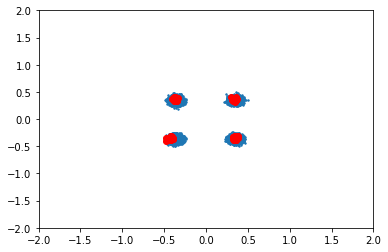

ep:171, D_real_loss: 0.7792, D_fake_loss: 0.5970, D_out_fk: 0.4494,D_out_rl: 0.4498, G_loss: -0.5487, M_loss: 1.3488
g1:4.2344388930359855e-05, g2:-8.966291716205887e-06
ep:172, D_real_loss: 0.7765, D_fake_loss: 0.5966, D_out_fk: 0.4492,D_out_rl: 0.4513, G_loss: -0.5617, M_loss: 1.3624
g1:0.0004938315832987428, g2:0.0006225517718121409
ep:173, D_real_loss: 0.7800, D_fake_loss: 0.5946, D_out_fk: 0.4482,D_out_rl: 0.4492, G_loss: -0.6498, M_loss: 1.4525
g1:0.0003755971556529403, g2:0.00037725421134382486
ep:174, D_real_loss: 0.7767, D_fake_loss: 0.5942, D_out_fk: 0.4479,D_out_rl: 0.4511, G_loss: -0.6878, M_loss: 1.4913
g1:0.0004486807156354189, g2:0.0003550630062818527
ep:175, D_real_loss: 0.7800, D_fake_loss: 0.5994, D_out_fk: 0.4507,D_out_rl: 0.4493, G_loss: -0.5478, M_loss: 1.3451
g1:0.0001448009570594877, g2:0.00018598414317239076
ep:176, D_real_loss: 0.7795, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4495, G_loss: -0.6394, M_loss: 1.4396
g1:-9.113778651226312e-05, g2:-5.445786

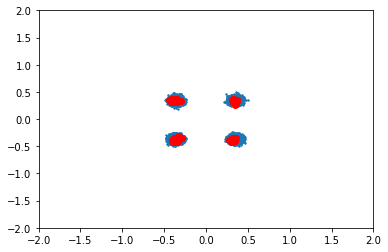

ep:181, D_real_loss: 0.7760, D_fake_loss: 0.5906, D_out_fk: 0.4457,D_out_rl: 0.4517, G_loss: -0.5822, M_loss: 1.3910
g1:0.0002937210665550083, g2:0.0003519869933370501
ep:182, D_real_loss: 0.7794, D_fake_loss: 0.6018, D_out_fk: 0.4517,D_out_rl: 0.4500, G_loss: -0.4465, M_loss: 1.2427
g1:0.00015513220569118857, g2:7.731805089861155e-05
ep:183, D_real_loss: 0.7792, D_fake_loss: 0.5926, D_out_fk: 0.4470,D_out_rl: 0.4497, G_loss: -0.7099, M_loss: 1.5153
g1:0.0003918990842066705, g2:0.00029533414635807276
ep:184, D_real_loss: 0.7799, D_fake_loss: 0.5954, D_out_fk: 0.4486,D_out_rl: 0.4494, G_loss: -0.4827, M_loss: 1.2846
g1:0.00024158901942428201, g2:0.00020261190365999937
ep:185, D_real_loss: 0.7745, D_fake_loss: 0.5962, D_out_fk: 0.4487,D_out_rl: 0.4526, G_loss: -0.5333, M_loss: 1.3357
g1:-0.00014562334399670362, g2:-0.0001312790554948151
ep:186, D_real_loss: 0.7776, D_fake_loss: 0.5966, D_out_fk: 0.4492,D_out_rl: 0.4506, G_loss: -0.6672, M_loss: 1.4675
g1:-1.7908067093230784e-05, g2:-7.76

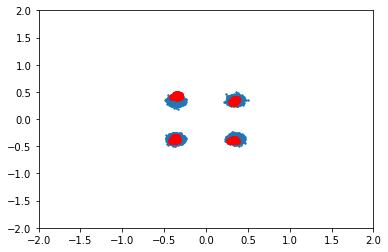

ep:191, D_real_loss: 0.7821, D_fake_loss: 0.5958, D_out_fk: 0.4485,D_out_rl: 0.4483, G_loss: -0.5032, M_loss: 1.3061
g1:0.00020217835844960064, g2:4.11707915191073e-05
ep:192, D_real_loss: 0.7804, D_fake_loss: 0.6009, D_out_fk: 0.4516,D_out_rl: 0.4490, G_loss: -0.7023, M_loss: 1.4975
g1:0.00016147701535373926, g2:7.077200280036777e-05
ep:193, D_real_loss: 0.7796, D_fake_loss: 0.5971, D_out_fk: 0.4496,D_out_rl: 0.4494, G_loss: -0.6035, M_loss: 1.4030
g1:-0.0001281981822103262, g2:-6.0387097619241104e-05
ep:194, D_real_loss: 0.7781, D_fake_loss: 0.5983, D_out_fk: 0.4502,D_out_rl: 0.4502, G_loss: -0.6372, M_loss: 1.4354
g1:3.131578705506399e-05, g2:5.7068518799496815e-05
ep:195, D_real_loss: 0.7773, D_fake_loss: 0.5943, D_out_fk: 0.4480,D_out_rl: 0.4506, G_loss: -0.7581, M_loss: 1.5610
g1:0.00019017321756109595, g2:0.00014806700346525759
ep:196, D_real_loss: 0.7770, D_fake_loss: 0.5974, D_out_fk: 0.4498,D_out_rl: 0.4508, G_loss: -0.4835, M_loss: 1.2825
g1:-0.0003274221671745181, g2:-0.000

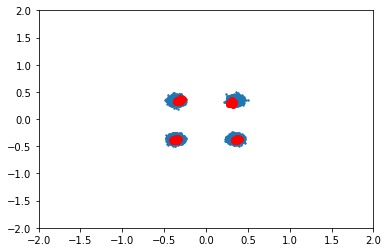

ep:201, D_real_loss: 0.7781, D_fake_loss: 0.5970, D_out_fk: 0.4493,D_out_rl: 0.4505, G_loss: -0.8862, M_loss: 1.6867
g1:-0.00017845723778009415, g2:-0.0001826738880481571
ep:202, D_real_loss: 0.7782, D_fake_loss: 0.5988, D_out_fk: 0.4505,D_out_rl: 0.4502, G_loss: -0.5862, M_loss: 1.3838
g1:0.0002022738626692444, g2:0.0002515585510991514
ep:203, D_real_loss: 0.7764, D_fake_loss: 0.5903, D_out_fk: 0.4458,D_out_rl: 0.4513, G_loss: -0.4795, M_loss: 1.2878
g1:0.00019545224495232105, g2:0.00019029827672056854
ep:204, D_real_loss: 0.7800, D_fake_loss: 0.6019, D_out_fk: 0.4521,D_out_rl: 0.4494, G_loss: -0.8381, M_loss: 1.6321
g1:-5.630142368318047e-06, g2:-0.00018877876573242247
ep:205, D_real_loss: 0.7803, D_fake_loss: 0.6012, D_out_fk: 0.4515,D_out_rl: 0.4497, G_loss: -0.5306, M_loss: 1.3269
g1:0.000572238233871758, g2:0.0005332935252226889
ep:206, D_real_loss: 0.7770, D_fake_loss: 0.5955, D_out_fk: 0.4485,D_out_rl: 0.4511, G_loss: -0.5659, M_loss: 1.3682
g1:-0.00023857645282987505, g2:-9.12

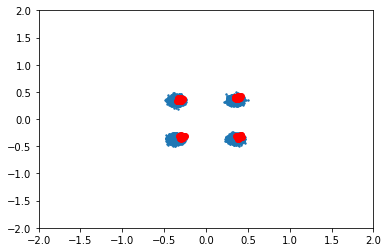

ep:211, D_real_loss: 0.7811, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4487, G_loss: -0.5543, M_loss: 1.3548
g1:3.224787360522896e-05, g2:0.00012370575859677047
ep:212, D_real_loss: 0.7758, D_fake_loss: 0.5938, D_out_fk: 0.4477,D_out_rl: 0.4516, G_loss: -0.5659, M_loss: 1.3698
g1:8.283335773739964e-05, g2:-3.694693077704869e-05
ep:213, D_real_loss: 0.7820, D_fake_loss: 0.6000, D_out_fk: 0.4511,D_out_rl: 0.4481, G_loss: -0.6319, M_loss: 1.4283
g1:-2.9742841434199363e-06, g2:-8.795850590104237e-05
ep:214, D_real_loss: 0.7823, D_fake_loss: 0.5997, D_out_fk: 0.4507,D_out_rl: 0.4484, G_loss: -0.6452, M_loss: 1.4431
g1:0.00010005542571889237, g2:7.892277790233493e-05
ep:215, D_real_loss: 0.7791, D_fake_loss: 0.5945, D_out_fk: 0.4479,D_out_rl: 0.4502, G_loss: -0.5706, M_loss: 1.3747
g1:-0.00038699444849044085, g2:-0.0004009795666206628
ep:216, D_real_loss: 0.7779, D_fake_loss: 0.6010, D_out_fk: 0.4517,D_out_rl: 0.4504, G_loss: -0.5163, M_loss: 1.3111
g1:0.00017384487728122622, g2:9.84

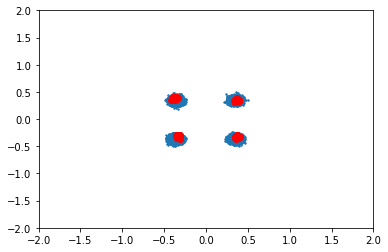

ep:221, D_real_loss: 0.7832, D_fake_loss: 0.6018, D_out_fk: 0.4521,D_out_rl: 0.4474, G_loss: -0.5417, M_loss: 1.3356
g1:0.00018336014181841165, g2:0.00019963043450843543
ep:222, D_real_loss: 0.7792, D_fake_loss: 0.5976, D_out_fk: 0.4497,D_out_rl: 0.4498, G_loss: -0.5270, M_loss: 1.3266
g1:6.850746285635978e-05, g2:-5.8737619838211685e-05
ep:223, D_real_loss: 0.7815, D_fake_loss: 0.5986, D_out_fk: 0.4504,D_out_rl: 0.4484, G_loss: -0.6042, M_loss: 1.4019
g1:-2.0145698726992123e-05, g2:2.8965836463612504e-05
ep:224, D_real_loss: 0.7742, D_fake_loss: 0.5961, D_out_fk: 0.4489,D_out_rl: 0.4525, G_loss: -0.4515, M_loss: 1.2531
g1:0.00023103112471289933, g2:9.788476018002257e-05
ep:225, D_real_loss: 0.7762, D_fake_loss: 0.5966, D_out_fk: 0.4492,D_out_rl: 0.4515, G_loss: -0.5505, M_loss: 1.3513
g1:9.207138646161184e-05, g2:0.0001347870274912566
ep:226, D_real_loss: 0.7785, D_fake_loss: 0.6020, D_out_fk: 0.4519,D_out_rl: 0.4504, G_loss: -0.5578, M_loss: 1.3530
g1:-0.00015893715317361057, g2:-0.0

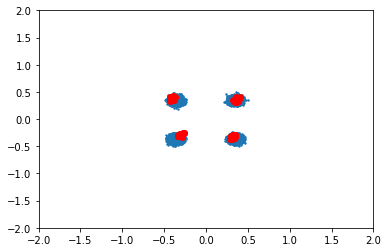

ep:231, D_real_loss: 0.7741, D_fake_loss: 0.5978, D_out_fk: 0.4499,D_out_rl: 0.4526, G_loss: -0.7414, M_loss: 1.5402
g1:0.00016398259322158992, g2:0.0003010555519722402
ep:232, D_real_loss: 0.7858, D_fake_loss: 0.5994, D_out_fk: 0.4508,D_out_rl: 0.4461, G_loss: -0.6117, M_loss: 1.4086
g1:0.00011821001680800691, g2:0.00018801797705236822
ep:233, D_real_loss: 0.7763, D_fake_loss: 0.5978, D_out_fk: 0.4499,D_out_rl: 0.4513, G_loss: -0.7307, M_loss: 1.5295
g1:0.0007355635752901435, g2:0.000696507457178086
ep:234, D_real_loss: 0.7819, D_fake_loss: 0.5966, D_out_fk: 0.4487,D_out_rl: 0.4492, G_loss: -0.5865, M_loss: 1.3894
g1:-4.020435426355107e-06, g2:6.448377826018259e-05
ep:235, D_real_loss: 0.7742, D_fake_loss: 0.5956, D_out_fk: 0.4487,D_out_rl: 0.4525, G_loss: -0.7244, M_loss: 1.5262
g1:0.00024265878892038018, g2:0.00020546976884361356
ep:236, D_real_loss: 0.7788, D_fake_loss: 0.5980, D_out_fk: 0.4500,D_out_rl: 0.4500, G_loss: -0.5957, M_loss: 1.3947
g1:1.3370176020544022e-05, g2:-8.04581

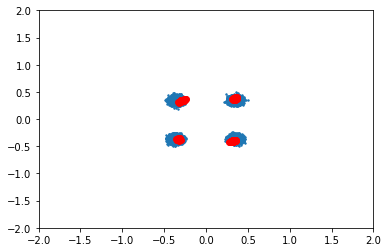

ep:241, D_real_loss: 0.7879, D_fake_loss: 0.6067, D_out_fk: 0.4548,D_out_rl: 0.4451, G_loss: -0.7016, M_loss: 1.4896
g1:-0.0002451485488563776, g2:-8.023231930565089e-05
ep:242, D_real_loss: 0.7794, D_fake_loss: 0.5953, D_out_fk: 0.4485,D_out_rl: 0.4496, G_loss: -0.3619, M_loss: 1.1641
g1:0.0003491762327030301, g2:0.00022886694932822138
ep:243, D_real_loss: 0.7782, D_fake_loss: 0.6003, D_out_fk: 0.4513,D_out_rl: 0.4502, G_loss: -0.8062, M_loss: 1.6021
g1:-0.0002381654194323346, g2:-0.0002988585038110614
ep:244, D_real_loss: 0.7774, D_fake_loss: 0.6000, D_out_fk: 0.4511,D_out_rl: 0.4506, G_loss: -0.6359, M_loss: 1.4320
g1:0.00014936864317860454, g2:0.00019984027312602848
ep:245, D_real_loss: 0.7792, D_fake_loss: 0.5978, D_out_fk: 0.4500,D_out_rl: 0.4496, G_loss: -0.5193, M_loss: 1.3178
g1:-2.283528920088429e-05, g2:4.670925409300253e-05
ep:246, D_real_loss: 0.7783, D_fake_loss: 0.5970, D_out_fk: 0.4495,D_out_rl: 0.4501, G_loss: -0.5355, M_loss: 1.3352
g1:0.00012124114437028766, g2:9.112

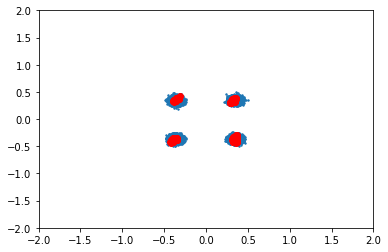

ep:251, D_real_loss: 0.7776, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4505, G_loss: -0.5849, M_loss: 1.3849
g1:-0.000313327822368592, g2:-0.00034939972101710737
ep:252, D_real_loss: 0.7736, D_fake_loss: 0.5950, D_out_fk: 0.4484,D_out_rl: 0.4528, G_loss: -0.5666, M_loss: 1.3688
g1:-0.0003510093374643475, g2:-0.0003049092774745077
ep:253, D_real_loss: 0.7782, D_fake_loss: 0.5965, D_out_fk: 0.4490,D_out_rl: 0.4505, G_loss: -0.5161, M_loss: 1.3175
g1:-3.463353277766146e-05, g2:-8.771447028266266e-05
ep:254, D_real_loss: 0.7757, D_fake_loss: 0.5957, D_out_fk: 0.4487,D_out_rl: 0.4516, G_loss: -0.5612, M_loss: 1.3627
g1:-5.0385078793624416e-05, g2:-0.0001109718214138411
ep:255, D_real_loss: 0.7762, D_fake_loss: 0.5938, D_out_fk: 0.4477,D_out_rl: 0.4514, G_loss: -0.6185, M_loss: 1.4226
g1:3.2670835935277864e-05, g2:2.464723729644902e-05
ep:256, D_real_loss: 0.7756, D_fake_loss: 0.5925, D_out_fk: 0.4470,D_out_rl: 0.4517, G_loss: -0.5578, M_loss: 1.3632
g1:-7.814745003997814e-06, g2:-1.

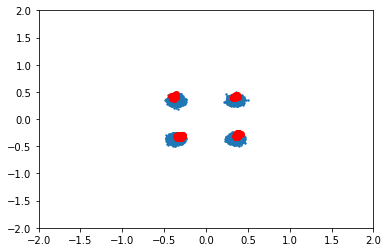

ep:261, D_real_loss: 0.7803, D_fake_loss: 0.5973, D_out_fk: 0.4495,D_out_rl: 0.4493, G_loss: -0.4921, M_loss: 1.2923
g1:3.112696504103951e-05, g2:-3.717220533872023e-05
ep:262, D_real_loss: 0.7785, D_fake_loss: 0.5973, D_out_fk: 0.4496,D_out_rl: 0.4501, G_loss: -0.4579, M_loss: 1.2575
g1:5.7398330682190135e-05, g2:3.0531606171280146e-05
ep:263, D_real_loss: 0.7816, D_fake_loss: 0.5965, D_out_fk: 0.4490,D_out_rl: 0.4487, G_loss: -0.5549, M_loss: 1.3563
g1:0.00014198588905856013, g2:0.00019333419913891703
ep:264, D_real_loss: 0.7772, D_fake_loss: 0.5961, D_out_fk: 0.4489,D_out_rl: 0.4508, G_loss: -0.5963, M_loss: 1.3978
g1:0.0001431993441656232, g2:0.00019032135605812073
ep:265, D_real_loss: 0.7791, D_fake_loss: 0.5976, D_out_fk: 0.4497,D_out_rl: 0.4500, G_loss: -0.6022, M_loss: 1.4021
g1:0.00010723122250055894, g2:8.112697105389088e-05
ep:266, D_real_loss: 0.7786, D_fake_loss: 0.5946, D_out_fk: 0.4482,D_out_rl: 0.4500, G_loss: -0.5818, M_loss: 1.3844
g1:5.598230200121179e-05, g2:6.35222

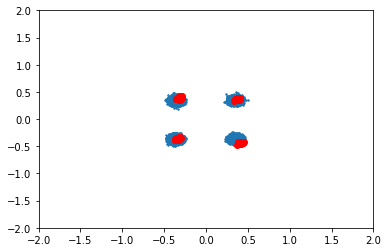

ep:271, D_real_loss: 0.7797, D_fake_loss: 0.5982, D_out_fk: 0.4502,D_out_rl: 0.4494, G_loss: -0.6042, M_loss: 1.4024
g1:0.00027899531414732337, g2:0.00016510969726368785
ep:272, D_real_loss: 0.7749, D_fake_loss: 0.5959, D_out_fk: 0.4489,D_out_rl: 0.4521, G_loss: -0.5455, M_loss: 1.3467
g1:-0.0002587262133602053, g2:-0.0002376165648456663
ep:273, D_real_loss: 0.7787, D_fake_loss: 0.5969, D_out_fk: 0.4494,D_out_rl: 0.4499, G_loss: -0.6180, M_loss: 1.4180
g1:3.277746509411372e-05, g2:9.957129805115983e-05
ep:274, D_real_loss: 0.7769, D_fake_loss: 0.5980, D_out_fk: 0.4500,D_out_rl: 0.4510, G_loss: -0.4013, M_loss: 1.2000
g1:-0.00020375143503770232, g2:-0.0002278401516377926
ep:275, D_real_loss: 0.7780, D_fake_loss: 0.5976, D_out_fk: 0.4498,D_out_rl: 0.4504, G_loss: -0.7058, M_loss: 1.5049
g1:0.00011890407040482387, g2:0.00014968166942708194
ep:276, D_real_loss: 0.7787, D_fake_loss: 0.5970, D_out_fk: 0.4495,D_out_rl: 0.4499, G_loss: -0.6424, M_loss: 1.4421
g1:-2.6656618501874618e-05, g2:1.8

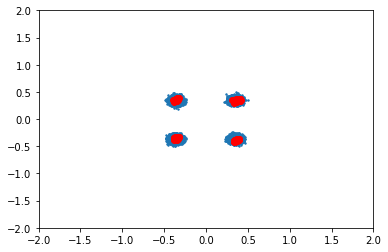

ep:281, D_real_loss: 0.7778, D_fake_loss: 0.5948, D_out_fk: 0.4483,D_out_rl: 0.4504, G_loss: -0.4838, M_loss: 1.2863
g1:3.5443656088318676e-05, g2:6.210061656020116e-06
ep:282, D_real_loss: 0.7781, D_fake_loss: 0.5975, D_out_fk: 0.4498,D_out_rl: 0.4503, G_loss: -0.5134, M_loss: 1.3126
g1:0.00011576103133847937, g2:0.00011875425116159022
ep:283, D_real_loss: 0.7782, D_fake_loss: 0.5963, D_out_fk: 0.4491,D_out_rl: 0.4503, G_loss: -0.5494, M_loss: 1.3500
g1:2.9451439331751317e-05, g2:-2.6951212930725887e-05
ep:284, D_real_loss: 0.7792, D_fake_loss: 0.5974, D_out_fk: 0.4497,D_out_rl: 0.4497, G_loss: -0.6107, M_loss: 1.4101
g1:-7.194756472017616e-05, g2:5.23867083757068e-06
ep:285, D_real_loss: 0.7780, D_fake_loss: 0.5954, D_out_fk: 0.4486,D_out_rl: 0.4504, G_loss: -0.5733, M_loss: 1.3752
g1:-9.278243851440493e-06, g2:-8.479061943944544e-05
ep:286, D_real_loss: 0.7804, D_fake_loss: 0.5975, D_out_fk: 0.4498,D_out_rl: 0.4490, G_loss: -0.6009, M_loss: 1.4000
g1:4.052529402542859e-05, g2:3.5570

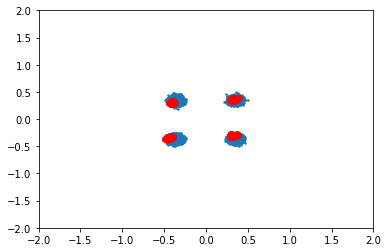

ep:291, D_real_loss: 0.7770, D_fake_loss: 0.5979, D_out_fk: 0.4499,D_out_rl: 0.4510, G_loss: -0.5177, M_loss: 1.3167
g1:0.0001967460266314447, g2:0.00018291194282937795
ep:292, D_real_loss: 0.7808, D_fake_loss: 0.5972, D_out_fk: 0.4495,D_out_rl: 0.4490, G_loss: -0.5087, M_loss: 1.3088
g1:9.001592843560502e-05, g2:0.0001275211398024112
ep:293, D_real_loss: 0.7791, D_fake_loss: 0.5981, D_out_fk: 0.4501,D_out_rl: 0.4497, G_loss: -0.6046, M_loss: 1.4030
g1:0.0002606985508464277, g2:0.00032907968852669
ep:294, D_real_loss: 0.7774, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4507, G_loss: -0.6090, M_loss: 1.4092
g1:8.819765753287356e-06, g2:-4.440707198227756e-05
ep:295, D_real_loss: 0.7797, D_fake_loss: 0.5968, D_out_fk: 0.4494,D_out_rl: 0.4494, G_loss: -0.4298, M_loss: 1.2298
g1:8.359565981663764e-07, g2:2.3164175217971206e-06
ep:296, D_real_loss: 0.7786, D_fake_loss: 0.5983, D_out_fk: 0.4502,D_out_rl: 0.4500, G_loss: -0.5149, M_loss: 1.3131
g1:1.887204052763991e-05, g2:3.22975392919

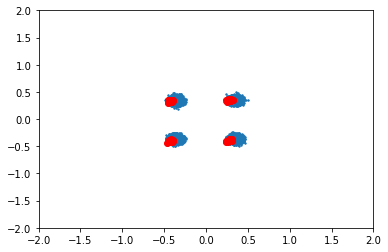

ep:301, D_real_loss: 0.7764, D_fake_loss: 0.5951, D_out_fk: 0.4484,D_out_rl: 0.4512, G_loss: -0.5494, M_loss: 1.3515
g1:2.8273170755710453e-05, g2:1.0819010640261695e-05
ep:302, D_real_loss: 0.7783, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4501, G_loss: -0.3909, M_loss: 1.1911
g1:0.0001606697915121913, g2:0.00017633356037549675
ep:303, D_real_loss: 0.7761, D_fake_loss: 0.5958, D_out_fk: 0.4488,D_out_rl: 0.4514, G_loss: -0.5049, M_loss: 1.3061
g1:-7.837398152332753e-05, g2:-8.33678204799071e-05
ep:304, D_real_loss: 0.7799, D_fake_loss: 0.5985, D_out_fk: 0.4503,D_out_rl: 0.4492, G_loss: -0.6821, M_loss: 1.4800
g1:-4.625841756933369e-05, g2:-7.41663170629181e-05
ep:305, D_real_loss: 0.7792, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4496, G_loss: -0.6731, M_loss: 1.4731
g1:0.0002619597944431007, g2:0.0002616606652736664
ep:306, D_real_loss: 0.7781, D_fake_loss: 0.5962, D_out_fk: 0.4491,D_out_rl: 0.4502, G_loss: -0.4533, M_loss: 1.2539
g1:-0.00018323528638575226, g2:-0.0002

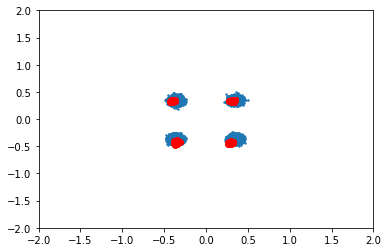

ep:311, D_real_loss: 0.7778, D_fake_loss: 0.5975, D_out_fk: 0.4498,D_out_rl: 0.4504, G_loss: -0.5675, M_loss: 1.3664
g1:-1.6416834114352241e-06, g2:-8.388504284084775e-06
ep:312, D_real_loss: 0.7819, D_fake_loss: 0.6007, D_out_fk: 0.4514,D_out_rl: 0.4483, G_loss: -0.6765, M_loss: 1.4724
g1:-0.00026374461594969034, g2:-0.00017591254436410964
ep:313, D_real_loss: 0.7757, D_fake_loss: 0.5961, D_out_fk: 0.4489,D_out_rl: 0.4516, G_loss: -0.7535, M_loss: 1.5550
g1:9.200684871757403e-05, g2:3.489748269203119e-05
ep:314, D_real_loss: 0.7804, D_fake_loss: 0.5994, D_out_fk: 0.4507,D_out_rl: 0.4491, G_loss: -0.6051, M_loss: 1.4024
g1:-0.00019272098143119365, g2:-0.0002861926332116127
ep:315, D_real_loss: 0.7805, D_fake_loss: 0.5996, D_out_fk: 0.4507,D_out_rl: 0.4492, G_loss: -0.7344, M_loss: 1.5321
g1:1.9467192942101974e-06, g2:-1.4128037946647964e-05
ep:316, D_real_loss: 0.7785, D_fake_loss: 0.5974, D_out_fk: 0.4497,D_out_rl: 0.4500, G_loss: -0.8235, M_loss: 1.6228
g1:-0.0005044514546170831, g2:

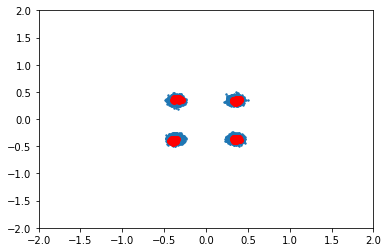

ep:321, D_real_loss: 0.7783, D_fake_loss: 0.5948, D_out_fk: 0.4482,D_out_rl: 0.4502, G_loss: -0.7384, M_loss: 1.5411
g1:0.0001061548973666504, g2:3.0873216019244865e-06
ep:322, D_real_loss: 0.7785, D_fake_loss: 0.5986, D_out_fk: 0.4504,D_out_rl: 0.4500, G_loss: -0.6527, M_loss: 1.4503
g1:0.0001410471450071782, g2:9.060393495019525e-05
ep:323, D_real_loss: 0.7804, D_fake_loss: 0.5990, D_out_fk: 0.4505,D_out_rl: 0.4490, G_loss: -0.5754, M_loss: 1.3731
g1:-0.00034469508682377636, g2:-0.00025853904662653804
ep:324, D_real_loss: 0.7777, D_fake_loss: 0.5951, D_out_fk: 0.4485,D_out_rl: 0.4505, G_loss: -0.6706, M_loss: 1.4727
g1:-1.795606476662215e-05, g2:8.16341253084829e-06
ep:325, D_real_loss: 0.7789, D_fake_loss: 0.6002, D_out_fk: 0.4511,D_out_rl: 0.4500, G_loss: -0.6031, M_loss: 1.3995
g1:-0.00014533408102579415, g2:-1.5802705092937686e-05
ep:326, D_real_loss: 0.7795, D_fake_loss: 0.5987, D_out_fk: 0.4503,D_out_rl: 0.4498, G_loss: -0.4123, M_loss: 1.2105
g1:0.00019929293193854392, g2:0.00

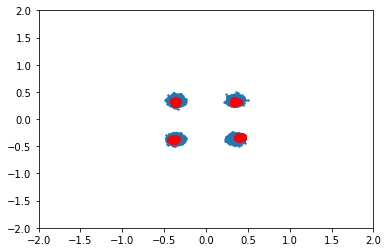

ep:331, D_real_loss: 0.7773, D_fake_loss: 0.5945, D_out_fk: 0.4481,D_out_rl: 0.4508, G_loss: -0.5419, M_loss: 1.3450
g1:9.236147161573172e-05, g2:2.0076759028597735e-05
ep:332, D_real_loss: 0.7752, D_fake_loss: 0.5972, D_out_fk: 0.4495,D_out_rl: 0.4521, G_loss: -0.4376, M_loss: 1.2378
g1:-0.0002801528025884181, g2:-0.0002128851629095152
ep:333, D_real_loss: 0.7753, D_fake_loss: 0.5967, D_out_fk: 0.4493,D_out_rl: 0.4519, G_loss: -0.5486, M_loss: 1.3490
g1:0.00016947599942795932, g2:0.00017409070278517902
ep:334, D_real_loss: 0.7773, D_fake_loss: 0.5957, D_out_fk: 0.4488,D_out_rl: 0.4506, G_loss: -0.5398, M_loss: 1.3409
g1:0.00012905840412713587, g2:0.00021243546507321298
ep:335, D_real_loss: 0.7788, D_fake_loss: 0.5951, D_out_fk: 0.4484,D_out_rl: 0.4499, G_loss: -0.5207, M_loss: 1.3228
g1:-0.0003907954378519207, g2:-0.00042727874824777246
ep:336, D_real_loss: 0.7812, D_fake_loss: 0.5995, D_out_fk: 0.4508,D_out_rl: 0.4488, G_loss: -0.6661, M_loss: 1.4634
g1:0.00013310628128238022, g2:0.0

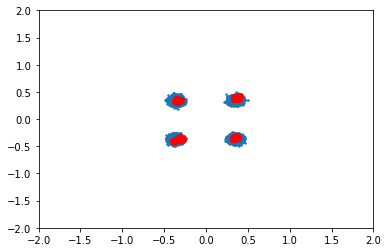

ep:341, D_real_loss: 0.7681, D_fake_loss: 0.5895, D_out_fk: 0.4445,D_out_rl: 0.4565, G_loss: -0.3909, M_loss: 1.2046
g1:0.0002290292759425938, g2:6.193209992488846e-05
ep:342, D_real_loss: 0.7845, D_fake_loss: 0.6082, D_out_fk: 0.4551,D_out_rl: 0.4470, G_loss: -0.5567, M_loss: 1.3454
g1:-0.00013896534801460803, g2:-4.6710083552170545e-05
ep:343, D_real_loss: 0.7813, D_fake_loss: 0.5986, D_out_fk: 0.4501,D_out_rl: 0.4488, G_loss: -0.6080, M_loss: 1.4070
g1:3.150706470478326e-05, g2:4.45916157332249e-06
ep:344, D_real_loss: 0.7811, D_fake_loss: 0.5986, D_out_fk: 0.4501,D_out_rl: 0.4491, G_loss: -0.5460, M_loss: 1.3450
g1:-3.945591379306279e-05, g2:-3.837739313894417e-06
ep:345, D_real_loss: 0.7803, D_fake_loss: 0.5988, D_out_fk: 0.4503,D_out_rl: 0.4493, G_loss: -0.6950, M_loss: 1.4933
g1:0.0002599351282697171, g2:0.0002647649380378425
ep:346, D_real_loss: 0.7766, D_fake_loss: 0.5963, D_out_fk: 0.4491,D_out_rl: 0.4511, G_loss: -0.5592, M_loss: 1.3601
g1:0.00012233236338943243, g2:0.000201

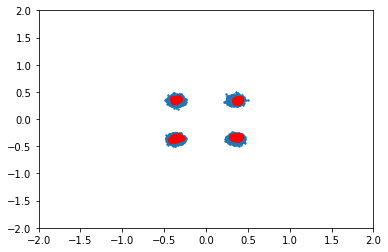

ep:351, D_real_loss: 0.7796, D_fake_loss: 0.5985, D_out_fk: 0.4503,D_out_rl: 0.4494, G_loss: -0.7890, M_loss: 1.5868
g1:5.678672096109949e-06, g2:8.424001862294972e-05
ep:352, D_real_loss: 0.7784, D_fake_loss: 0.5985, D_out_fk: 0.4503,D_out_rl: 0.4501, G_loss: -0.7939, M_loss: 1.5920
g1:0.00018097733845934272, g2:0.00010322022717446089
ep:353, D_real_loss: 0.7787, D_fake_loss: 0.5988, D_out_fk: 0.4505,D_out_rl: 0.4499, G_loss: -0.6681, M_loss: 1.4656
g1:-0.00030304776737466455, g2:-0.00033359136432409286
ep:354, D_real_loss: 0.7783, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4501, G_loss: -0.7198, M_loss: 1.5191
g1:-4.587440344039351e-05, g2:-2.5660563551355153e-05
ep:355, D_real_loss: 0.7780, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4503, G_loss: -0.5019, M_loss: 1.3011
g1:-3.62304926966317e-05, g2:-3.7491106922971085e-05
ep:356, D_real_loss: 0.7783, D_fake_loss: 0.5982, D_out_fk: 0.4502,D_out_rl: 0.4501, G_loss: -0.7830, M_loss: 1.5811
g1:-1.5558145605609752e-05, g2:-

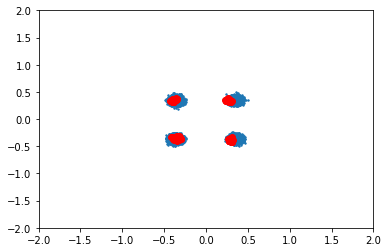

ep:361, D_real_loss: 0.7774, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4507, G_loss: -0.4040, M_loss: 1.2043
g1:8.266279473900795e-05, g2:0.00010374306293670088
ep:362, D_real_loss: 0.7782, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4502, G_loss: -0.5314, M_loss: 1.3307
g1:5.771438736701384e-06, g2:8.83873326529283e-06
ep:363, D_real_loss: 0.7753, D_fake_loss: 0.5962, D_out_fk: 0.4489,D_out_rl: 0.4520, G_loss: -0.6643, M_loss: 1.4655
g1:5.88558723393362e-05, g2:-7.852444468881004e-06
ep:364, D_real_loss: 0.7742, D_fake_loss: 0.5950, D_out_fk: 0.4483,D_out_rl: 0.4525, G_loss: -0.6394, M_loss: 1.4419
g1:0.000246064126258716, g2:0.00024533216492272913
ep:365, D_real_loss: 0.7761, D_fake_loss: 0.5950, D_out_fk: 0.4483,D_out_rl: 0.4516, G_loss: -0.5815, M_loss: 1.3844
g1:4.113449540454894e-05, g2:2.5470015316386707e-05
ep:366, D_real_loss: 0.7755, D_fake_loss: 0.5968, D_out_fk: 0.4493,D_out_rl: 0.4518, G_loss: -0.5078, M_loss: 1.3085
g1:-6.936906720511615e-05, g2:-8.603361493

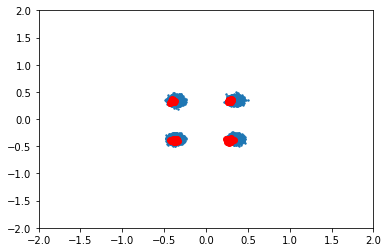

ep:371, D_real_loss: 0.7794, D_fake_loss: 0.5959, D_out_fk: 0.4488,D_out_rl: 0.4496, G_loss: -0.6352, M_loss: 1.4366
g1:0.0001295437105000019, g2:0.0001236315438291058
ep:372, D_real_loss: 0.7776, D_fake_loss: 0.5964, D_out_fk: 0.4492,D_out_rl: 0.4505, G_loss: -0.4589, M_loss: 1.2593
g1:-1.3779540495306719e-05, g2:-4.3169369746465236e-05
ep:373, D_real_loss: 0.7775, D_fake_loss: 0.5963, D_out_fk: 0.4491,D_out_rl: 0.4506, G_loss: -0.6940, M_loss: 1.4945
g1:-7.328864012379199e-05, g2:-2.8192731406306848e-05
ep:374, D_real_loss: 0.7789, D_fake_loss: 0.5967, D_out_fk: 0.4494,D_out_rl: 0.4498, G_loss: -0.5317, M_loss: 1.3317
g1:0.00012486665218602866, g2:0.00013859276077710092
ep:375, D_real_loss: 0.7775, D_fake_loss: 0.5977, D_out_fk: 0.4499,D_out_rl: 0.4506, G_loss: -0.5619, M_loss: 1.3607
g1:-2.367682827753015e-05, g2:-5.5648993111390155e-06
ep:376, D_real_loss: 0.7793, D_fake_loss: 0.5982, D_out_fk: 0.4502,D_out_rl: 0.4495, G_loss: -0.5521, M_loss: 1.3503
g1:-0.0001093314349418506, g2:-

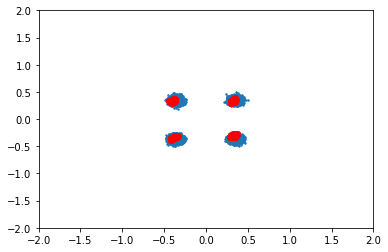

ep:381, D_real_loss: 0.7787, D_fake_loss: 0.5958, D_out_fk: 0.4487,D_out_rl: 0.4502, G_loss: -0.4773, M_loss: 1.2793
g1:-7.115878543118015e-05, g2:6.261571252252907e-05
ep:382, D_real_loss: 0.7788, D_fake_loss: 0.5955, D_out_fk: 0.4486,D_out_rl: 0.4500, G_loss: -0.6190, M_loss: 1.4212
g1:0.0002924843574874103, g2:0.0002755683090072125
ep:383, D_real_loss: 0.7795, D_fake_loss: 0.5991, D_out_fk: 0.4506,D_out_rl: 0.4495, G_loss: -0.5460, M_loss: 1.3432
g1:0.0003029417130164802, g2:0.00022374166292138398
ep:384, D_real_loss: 0.7795, D_fake_loss: 0.5963, D_out_fk: 0.4490,D_out_rl: 0.4497, G_loss: -0.6655, M_loss: 1.4666
g1:8.465184509987012e-05, g2:6.285236304393038e-05
ep:385, D_real_loss: 0.7797, D_fake_loss: 0.5964, D_out_fk: 0.4492,D_out_rl: 0.4494, G_loss: -0.6039, M_loss: 1.4044
g1:6.674762516922783e-06, g2:7.757027196930721e-05
ep:386, D_real_loss: 0.7789, D_fake_loss: 0.5943, D_out_fk: 0.4479,D_out_rl: 0.4499, G_loss: -0.8040, M_loss: 1.6075
g1:-2.6644323952496052e-05, g2:-4.0812152

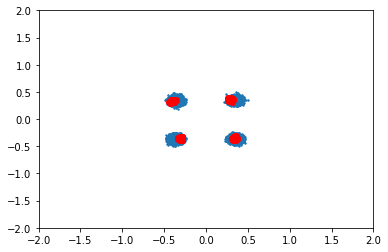

ep:391, D_real_loss: 0.7783, D_fake_loss: 0.5961, D_out_fk: 0.4489,D_out_rl: 0.4502, G_loss: -0.6122, M_loss: 1.4132
g1:-0.00019395837443880737, g2:-0.00017639290308579803
ep:392, D_real_loss: 0.7766, D_fake_loss: 0.5958, D_out_fk: 0.4487,D_out_rl: 0.4512, G_loss: -0.7531, M_loss: 1.5550
g1:-0.00012003985466435552, g2:-0.00011605367762967944
ep:393, D_real_loss: 0.7809, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4487, G_loss: -0.7616, M_loss: 1.5618
g1:-0.00018256121256854385, g2:-0.0001854373113019392
ep:394, D_real_loss: 0.7804, D_fake_loss: 0.5985, D_out_fk: 0.4502,D_out_rl: 0.4490, G_loss: -0.6100, M_loss: 1.4083
g1:-7.535207259934396e-05, g2:-5.762652563134907e-06
ep:395, D_real_loss: 0.7801, D_fake_loss: 0.5961, D_out_fk: 0.4490,D_out_rl: 0.4493, G_loss: -0.5808, M_loss: 1.3818
g1:-0.00010051114077214152, g2:-0.000157040951307863
ep:396, D_real_loss: 0.7761, D_fake_loss: 0.5941, D_out_fk: 0.4479,D_out_rl: 0.4513, G_loss: -0.6974, M_loss: 1.5008
g1:-6.261082307901233e-05, g

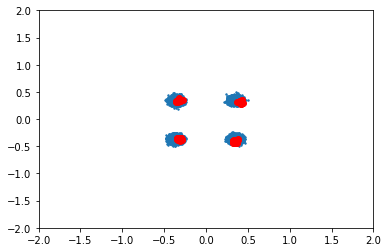

ep:401, D_real_loss: 0.7815, D_fake_loss: 0.5927, D_out_fk: 0.4469,D_out_rl: 0.4488, G_loss: -0.6223, M_loss: 1.4286
g1:0.00010877875320147723, g2:9.577321179676801e-05
ep:402, D_real_loss: 0.7807, D_fake_loss: 0.6012, D_out_fk: 0.4517,D_out_rl: 0.4489, G_loss: -0.5076, M_loss: 1.3026
g1:-9.037257404997945e-05, g2:-0.00010384358756709844
ep:403, D_real_loss: 0.7772, D_fake_loss: 0.5953, D_out_fk: 0.4484,D_out_rl: 0.4509, G_loss: -0.7111, M_loss: 1.5134
g1:-8.290091500384733e-05, g2:-2.0569861590047367e-05
ep:404, D_real_loss: 0.7796, D_fake_loss: 0.5995, D_out_fk: 0.4509,D_out_rl: 0.4494, G_loss: -0.6738, M_loss: 1.4703
g1:8.835142944008112e-05, g2:7.940059731481597e-05
ep:405, D_real_loss: 0.7796, D_fake_loss: 0.5978, D_out_fk: 0.4500,D_out_rl: 0.4494, G_loss: -0.6299, M_loss: 1.4286
g1:0.000136235510581173, g2:6.463920726673678e-05
ep:406, D_real_loss: 0.7735, D_fake_loss: 0.5889, D_out_fk: 0.4450,D_out_rl: 0.4530, G_loss: -0.5286, M_loss: 1.3386
g1:5.103385774418712e-06, g2:0.000119

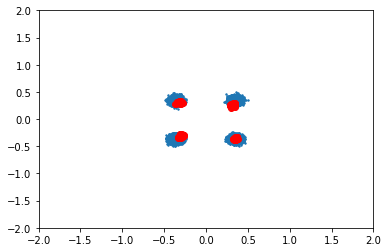

ep:411, D_real_loss: 0.7806, D_fake_loss: 0.5979, D_out_fk: 0.4500,D_out_rl: 0.4489, G_loss: -0.4817, M_loss: 1.2803
g1:-0.00022626473219133914, g2:-0.00012349015742074698
ep:412, D_real_loss: 0.7746, D_fake_loss: 0.5956, D_out_fk: 0.4485,D_out_rl: 0.4525, G_loss: -0.5990, M_loss: 1.4017
g1:-0.00016591380699537694, g2:-0.00019962931401096284
ep:413, D_real_loss: 0.7791, D_fake_loss: 0.5986, D_out_fk: 0.4504,D_out_rl: 0.4498, G_loss: -0.6518, M_loss: 1.4497
g1:-0.00034100335324183106, g2:-0.00029064249247312546
ep:414, D_real_loss: 0.7804, D_fake_loss: 0.5954, D_out_fk: 0.4486,D_out_rl: 0.4490, G_loss: -0.7373, M_loss: 1.5389
g1:-0.00011680150782922283, g2:-8.687587978783995e-05
ep:415, D_real_loss: 0.7800, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4492, G_loss: -0.5554, M_loss: 1.3547
g1:-2.3620819774805568e-05, g2:-0.00010096211190102622
ep:416, D_real_loss: 0.7798, D_fake_loss: 0.5990, D_out_fk: 0.4506,D_out_rl: 0.4493, G_loss: -0.5627, M_loss: 1.3598
g1:0.0001032111176755279

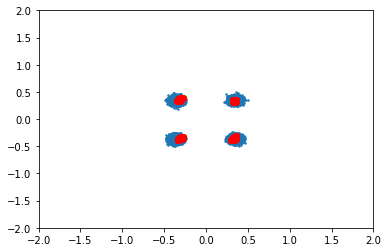

ep:421, D_real_loss: 0.7788, D_fake_loss: 0.5970, D_out_fk: 0.4495,D_out_rl: 0.4498, G_loss: -0.5863, M_loss: 1.3860
g1:-4.866072049480863e-05, g2:-2.036590922216419e-05
ep:422, D_real_loss: 0.7787, D_fake_loss: 0.5981, D_out_fk: 0.4501,D_out_rl: 0.4500, G_loss: -0.5740, M_loss: 1.3725
g1:-8.5695312009193e-05, g2:-6.879709690110758e-05
ep:423, D_real_loss: 0.7788, D_fake_loss: 0.5969, D_out_fk: 0.4495,D_out_rl: 0.4499, G_loss: -0.3605, M_loss: 1.1602
g1:0.00012635970779228956, g2:7.755195838399231e-05
ep:424, D_real_loss: 0.7778, D_fake_loss: 0.5976, D_out_fk: 0.4498,D_out_rl: 0.4504, G_loss: -0.5753, M_loss: 1.3743
g1:-0.0002925095905084163, g2:-0.0003332881024107337
ep:425, D_real_loss: 0.7793, D_fake_loss: 0.5976, D_out_fk: 0.4498,D_out_rl: 0.4496, G_loss: -0.5475, M_loss: 1.3465
g1:-2.8700313123408705e-05, g2:8.959851402323693e-05
ep:426, D_real_loss: 0.7793, D_fake_loss: 0.6003, D_out_fk: 0.4514,D_out_rl: 0.4496, G_loss: -0.6555, M_loss: 1.4511
g1:0.0002751092833932489, g2:0.00019

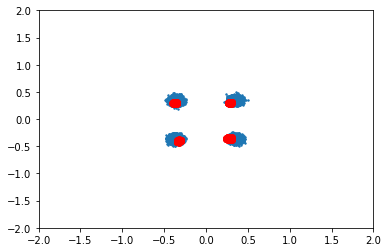

ep:431, D_real_loss: 0.7817, D_fake_loss: 0.6006, D_out_fk: 0.4515,D_out_rl: 0.4483, G_loss: -0.6335, M_loss: 1.4289
g1:-0.000335893128067255, g2:-0.0003065575729124248
ep:432, D_real_loss: 0.7772, D_fake_loss: 0.5958, D_out_fk: 0.4488,D_out_rl: 0.4507, G_loss: -0.5376, M_loss: 1.3388
g1:-0.00016407473594881594, g2:-0.00018601703050080687
ep:433, D_real_loss: 0.7789, D_fake_loss: 0.5994, D_out_fk: 0.4509,D_out_rl: 0.4498, G_loss: -0.6520, M_loss: 1.4486
g1:5.712002166546881e-05, g2:3.852735972031951e-05
ep:434, D_real_loss: 0.7787, D_fake_loss: 0.5953, D_out_fk: 0.4485,D_out_rl: 0.4500, G_loss: -0.6135, M_loss: 1.4154
g1:-2.695403600228019e-05, g2:1.2160917322034948e-06
ep:435, D_real_loss: 0.7784, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4501, G_loss: -0.5487, M_loss: 1.3490
g1:6.255601329030469e-05, g2:6.851273064967245e-05
ep:436, D_real_loss: 0.7771, D_fake_loss: 0.5955, D_out_fk: 0.4487,D_out_rl: 0.4509, G_loss: -0.6156, M_loss: 1.4172
g1:0.0002517189714126289, g2:0.00025

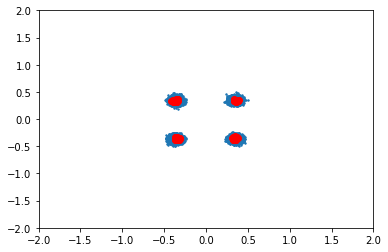

ep:441, D_real_loss: 0.7788, D_fake_loss: 0.5986, D_out_fk: 0.4504,D_out_rl: 0.4498, G_loss: -0.7968, M_loss: 1.5945
g1:-5.973027873551473e-05, g2:-1.9885355868609622e-05
ep:442, D_real_loss: 0.7774, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4506, G_loss: -0.5551, M_loss: 1.3545
g1:-2.1840537556272466e-06, g2:-2.414378286630381e-05
ep:443, D_real_loss: 0.7780, D_fake_loss: 0.5983, D_out_fk: 0.4502,D_out_rl: 0.4503, G_loss: -0.6384, M_loss: 1.4365
g1:6.736840987286996e-06, g2:-2.173201210098341e-05
ep:444, D_real_loss: 0.7764, D_fake_loss: 0.5968, D_out_fk: 0.4494,D_out_rl: 0.4512, G_loss: -0.6984, M_loss: 1.4983
g1:-3.4069693356286734e-05, g2:2.1988216758472845e-05
ep:445, D_real_loss: 0.7791, D_fake_loss: 0.5983, D_out_fk: 0.4502,D_out_rl: 0.4498, G_loss: -0.5082, M_loss: 1.3065
g1:1.2730141861538868e-05, g2:3.044159893761389e-05
ep:446, D_real_loss: 0.7754, D_fake_loss: 0.5939, D_out_fk: 0.4478,D_out_rl: 0.4517, G_loss: -0.5959, M_loss: 1.3996
g1:0.00012402840366121382, g2:8.

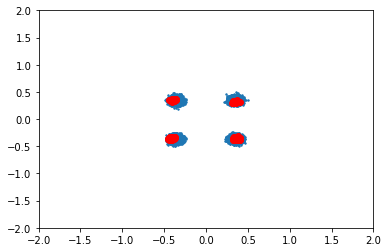

ep:451, D_real_loss: 0.7779, D_fake_loss: 0.5968, D_out_fk: 0.4494,D_out_rl: 0.4503, G_loss: -0.6617, M_loss: 1.4616
g1:8.503028948325664e-05, g2:4.486149555305019e-05
ep:452, D_real_loss: 0.7779, D_fake_loss: 0.5978, D_out_fk: 0.4499,D_out_rl: 0.4504, G_loss: -0.4745, M_loss: 1.2735
g1:5.86243586440105e-05, g2:4.309066753194202e-06
ep:453, D_real_loss: 0.7777, D_fake_loss: 0.5993, D_out_fk: 0.4507,D_out_rl: 0.4505, G_loss: -0.3885, M_loss: 1.1857
g1:0.00022497227473650128, g2:0.0002202698669862002
ep:454, D_real_loss: 0.7737, D_fake_loss: 0.5916, D_out_fk: 0.4463,D_out_rl: 0.4529, G_loss: -0.5810, M_loss: 1.3884
g1:0.00029587134486064315, g2:0.0003173772420268506
ep:455, D_real_loss: 0.7798, D_fake_loss: 0.5985, D_out_fk: 0.4504,D_out_rl: 0.4493, G_loss: -0.6892, M_loss: 1.4869
g1:4.692667425842956e-05, g2:6.429778295569122e-05
ep:456, D_real_loss: 0.7789, D_fake_loss: 0.5984, D_out_fk: 0.4502,D_out_rl: 0.4499, G_loss: -0.6393, M_loss: 1.4378
g1:-4.5654036512132734e-05, g2:-6.75813425

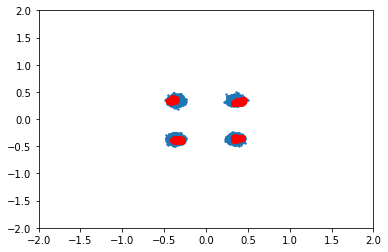

ep:461, D_real_loss: 0.7765, D_fake_loss: 0.5977, D_out_fk: 0.4498,D_out_rl: 0.4512, G_loss: -0.5360, M_loss: 1.3351
g1:0.0002856325590983033, g2:0.0001718268176773563
ep:462, D_real_loss: 0.7786, D_fake_loss: 0.5995, D_out_fk: 0.4508,D_out_rl: 0.4501, G_loss: -0.5452, M_loss: 1.3420
g1:-2.8987788027734496e-05, g2:-1.9608625734690577e-05
ep:463, D_real_loss: 0.7782, D_fake_loss: 0.5981, D_out_fk: 0.4501,D_out_rl: 0.4502, G_loss: -0.4411, M_loss: 1.2393
g1:0.00010502252553123981, g2:4.8264104407280684e-05
ep:464, D_real_loss: 0.7805, D_fake_loss: 0.5993, D_out_fk: 0.4507,D_out_rl: 0.4490, G_loss: -0.6780, M_loss: 1.4751
g1:-0.0001723643799778074, g2:-0.00014480765094049275
ep:465, D_real_loss: 0.7797, D_fake_loss: 0.5977, D_out_fk: 0.4497,D_out_rl: 0.4498, G_loss: -0.5065, M_loss: 1.3062
g1:-9.138941095443442e-05, g2:1.0593668775982223e-05
ep:466, D_real_loss: 0.7762, D_fake_loss: 0.5975, D_out_fk: 0.4496,D_out_rl: 0.4514, G_loss: -0.4966, M_loss: 1.2963
g1:0.00014734905562363565, g2:0.

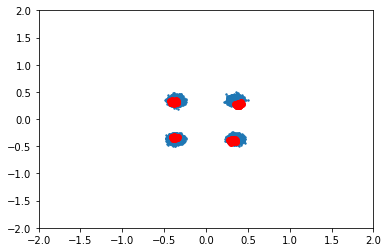

ep:471, D_real_loss: 0.7779, D_fake_loss: 0.5959, D_out_fk: 0.4489,D_out_rl: 0.4503, G_loss: -0.3643, M_loss: 1.1653
g1:3.639822898549028e-05, g2:6.043070607120171e-05
ep:472, D_real_loss: 0.7764, D_fake_loss: 0.5963, D_out_fk: 0.4491,D_out_rl: 0.4512, G_loss: -0.6844, M_loss: 1.4850
g1:0.00020096627122256905, g2:0.00017725017096381634
ep:473, D_real_loss: 0.7770, D_fake_loss: 0.5959, D_out_fk: 0.4489,D_out_rl: 0.4509, G_loss: -0.5817, M_loss: 1.3829
g1:-5.135085302754305e-05, g2:-3.6345554690342396e-05
ep:474, D_real_loss: 0.7793, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4496, G_loss: -0.6363, M_loss: 1.4366
g1:0.00024237421166617423, g2:0.00022508998517878354
ep:475, D_real_loss: 0.7783, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4502, G_loss: -0.7118, M_loss: 1.5124
g1:4.766947677126154e-05, g2:7.362935866694897e-05
ep:476, D_real_loss: 0.7818, D_fake_loss: 0.6026, D_out_fk: 0.4525,D_out_rl: 0.4483, G_loss: -0.4286, M_loss: 1.2220
g1:-5.4614656619378366e-06, g2:9.381

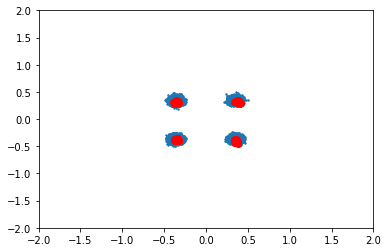

ep:481, D_real_loss: 0.7791, D_fake_loss: 0.5963, D_out_fk: 0.4490,D_out_rl: 0.4498, G_loss: -0.3643, M_loss: 1.1653
g1:2.316718382644467e-05, g2:2.854848571587354e-05
ep:482, D_real_loss: 0.7790, D_fake_loss: 0.5971, D_out_fk: 0.4496,D_out_rl: 0.4498, G_loss: -0.6116, M_loss: 1.4110
g1:0.00025173445465043187, g2:0.00023569677432533354
ep:483, D_real_loss: 0.7793, D_fake_loss: 0.5997, D_out_fk: 0.4510,D_out_rl: 0.4496, G_loss: -0.7324, M_loss: 1.5289
g1:-5.5020216677803546e-05, g2:-7.984462718013674e-05
ep:484, D_real_loss: 0.7775, D_fake_loss: 0.5970, D_out_fk: 0.4495,D_out_rl: 0.4506, G_loss: -0.4745, M_loss: 1.2742
g1:-4.0406132029602304e-05, g2:-2.4014070731936954e-05
ep:485, D_real_loss: 0.7781, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4502, G_loss: -0.7309, M_loss: 1.5311
g1:6.432946247514337e-05, g2:6.141845369711518e-05
ep:486, D_real_loss: 0.7764, D_fake_loss: 0.5971, D_out_fk: 0.4496,D_out_rl: 0.4511, G_loss: -0.3510, M_loss: 1.1505
g1:1.8909126083599404e-05, g2:1.36

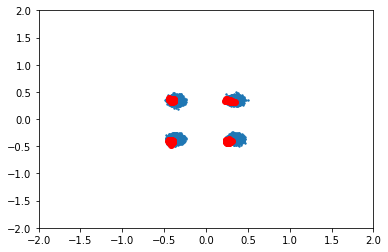

ep:491, D_real_loss: 0.7791, D_fake_loss: 0.5981, D_out_fk: 0.4501,D_out_rl: 0.4497, G_loss: -0.7748, M_loss: 1.5732
g1:-1.292343768000137e-06, g2:-4.610893483913969e-06
ep:492, D_real_loss: 0.7805, D_fake_loss: 0.5977, D_out_fk: 0.4499,D_out_rl: 0.4489, G_loss: -0.6184, M_loss: 1.4173
g1:-0.00017562293214723468, g2:-0.00011833987082354724
ep:493, D_real_loss: 0.7817, D_fake_loss: 0.6004, D_out_fk: 0.4513,D_out_rl: 0.4484, G_loss: -0.7525, M_loss: 1.5487
g1:-8.025259739952162e-05, g2:-2.7918384148506448e-05
ep:494, D_real_loss: 0.7789, D_fake_loss: 0.5986, D_out_fk: 0.4504,D_out_rl: 0.4498, G_loss: -0.5596, M_loss: 1.3573
g1:0.00020625289471354336, g2:0.00018081549205817282
ep:495, D_real_loss: 0.7788, D_fake_loss: 0.5984, D_out_fk: 0.4502,D_out_rl: 0.4499, G_loss: -0.6352, M_loss: 1.4334
g1:-0.0001113929902203381, g2:-0.00013958335330244154
ep:496, D_real_loss: 0.7783, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4502, G_loss: -0.5617, M_loss: 1.3623
g1:-0.00013700070849154145, g

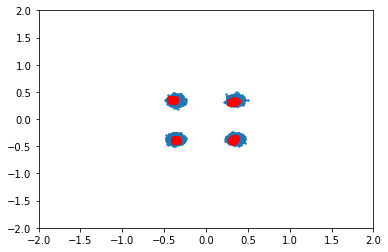

ep:501, D_real_loss: 0.7783, D_fake_loss: 0.5984, D_out_fk: 0.4503,D_out_rl: 0.4501, G_loss: -0.5470, M_loss: 1.3450
g1:-4.354049451649189e-05, g2:-3.455283149378374e-05
ep:502, D_real_loss: 0.7774, D_fake_loss: 0.5959, D_out_fk: 0.4489,D_out_rl: 0.4506, G_loss: -0.4111, M_loss: 1.2121
g1:-8.094611985143274e-05, g2:-6.604177178815007e-05
ep:503, D_real_loss: 0.7788, D_fake_loss: 0.5961, D_out_fk: 0.4490,D_out_rl: 0.4499, G_loss: -0.5850, M_loss: 1.3860
g1:4.5266519009601325e-05, g2:1.4295401342678815e-05
ep:504, D_real_loss: 0.7768, D_fake_loss: 0.5962, D_out_fk: 0.4490,D_out_rl: 0.4510, G_loss: -0.5672, M_loss: 1.3680
g1:-8.457688090857118e-05, g2:-9.659833449404687e-05
ep:505, D_real_loss: 0.7813, D_fake_loss: 0.5985, D_out_fk: 0.4503,D_out_rl: 0.4485, G_loss: -0.6049, M_loss: 1.4027
g1:-0.00017113159992732108, g2:-9.380066330777481e-05
ep:506, D_real_loss: 0.7773, D_fake_loss: 0.5951, D_out_fk: 0.4485,D_out_rl: 0.4506, G_loss: -0.5245, M_loss: 1.3264
g1:5.917257658438757e-05, g2:5.8

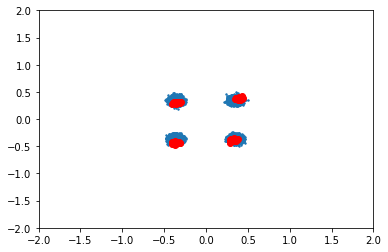

ep:511, D_real_loss: 0.7840, D_fake_loss: 0.6064, D_out_fk: 0.4545,D_out_rl: 0.4477, G_loss: -0.4922, M_loss: 1.2812
g1:2.575230428192299e-05, g2:2.2251744667300954e-05
ep:512, D_real_loss: 0.7821, D_fake_loss: 0.6009, D_out_fk: 0.4516,D_out_rl: 0.4482, G_loss: -0.3799, M_loss: 1.1750
g1:-0.00014672463294118643, g2:-0.0001887179969344288
ep:513, D_real_loss: 0.7724, D_fake_loss: 0.5914, D_out_fk: 0.4461,D_out_rl: 0.4542, G_loss: -0.4913, M_loss: 1.2996
g1:-6.483464676421136e-05, g2:-7.987116987351328e-05
ep:514, D_real_loss: 0.7784, D_fake_loss: 0.5976, D_out_fk: 0.4498,D_out_rl: 0.4502, G_loss: -0.6756, M_loss: 1.4748
g1:0.00016502835205756128, g2:0.0002637435682117939
ep:515, D_real_loss: 0.7795, D_fake_loss: 0.5995, D_out_fk: 0.4508,D_out_rl: 0.4496, G_loss: -0.7756, M_loss: 1.5728
g1:-4.722289304481819e-05, g2:-2.8551776267704554e-05
ep:516, D_real_loss: 0.7781, D_fake_loss: 0.5981, D_out_fk: 0.4501,D_out_rl: 0.4502, G_loss: -0.5996, M_loss: 1.3980
g1:0.00018972378165926784, g2:0.0

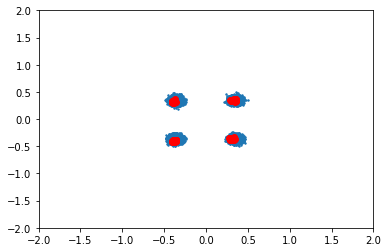

ep:521, D_real_loss: 0.7770, D_fake_loss: 0.5960, D_out_fk: 0.4489,D_out_rl: 0.4508, G_loss: -0.7106, M_loss: 1.5117
g1:0.00014130808995105326, g2:9.367470920551568e-05
ep:522, D_real_loss: 0.7772, D_fake_loss: 0.5973, D_out_fk: 0.4497,D_out_rl: 0.4507, G_loss: -0.6088, M_loss: 1.4080
g1:-0.00016732494987081736, g2:-0.0001545629493193701
ep:523, D_real_loss: 0.7806, D_fake_loss: 0.5995, D_out_fk: 0.4509,D_out_rl: 0.4488, G_loss: -0.4990, M_loss: 1.2955
g1:1.5913976767478744e-06, g2:1.3079691598250065e-05
ep:524, D_real_loss: 0.7779, D_fake_loss: 0.5968, D_out_fk: 0.4494,D_out_rl: 0.4504, G_loss: -0.6513, M_loss: 1.4512
g1:2.4146269424818456e-05, g2:1.3269088412926067e-05
ep:525, D_real_loss: 0.7779, D_fake_loss: 0.5974, D_out_fk: 0.4497,D_out_rl: 0.4503, G_loss: -0.5028, M_loss: 1.3019
g1:4.751441883854568e-05, g2:9.205689275404438e-05
ep:526, D_real_loss: 0.7782, D_fake_loss: 0.5970, D_out_fk: 0.4495,D_out_rl: 0.4502, G_loss: -0.2694, M_loss: 1.0690
g1:-0.00016210225294344127, g2:-0.0

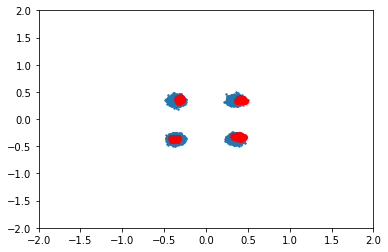

ep:531, D_real_loss: 0.7780, D_fake_loss: 0.5982, D_out_fk: 0.4502,D_out_rl: 0.4503, G_loss: -0.5265, M_loss: 1.3247
g1:-3.846322579192929e-05, g2:-1.0405105058453046e-05
ep:532, D_real_loss: 0.7803, D_fake_loss: 0.5965, D_out_fk: 0.4492,D_out_rl: 0.4492, G_loss: -0.6023, M_loss: 1.4028
g1:-5.611952656181529e-05, g2:1.5775594874867238e-07
ep:533, D_real_loss: 0.7839, D_fake_loss: 0.6032, D_out_fk: 0.4529,D_out_rl: 0.4474, G_loss: -0.5502, M_loss: 1.3424
g1:8.26415343908593e-05, g2:8.802044612821192e-05
ep:534, D_real_loss: 0.7814, D_fake_loss: 0.5996, D_out_fk: 0.4509,D_out_rl: 0.4485, G_loss: -0.5801, M_loss: 1.3769
g1:9.514543489785865e-05, g2:9.979263268178329e-05
ep:535, D_real_loss: 0.7807, D_fake_loss: 0.5996, D_out_fk: 0.4509,D_out_rl: 0.4489, G_loss: -0.6751, M_loss: 1.4717
g1:7.511043804697692e-05, g2:3.3917171094799414e-05
ep:536, D_real_loss: 0.7810, D_fake_loss: 0.5995, D_out_fk: 0.4508,D_out_rl: 0.4488, G_loss: -0.6221, M_loss: 1.4191
g1:-4.797152359969914e-05, g2:-3.99048

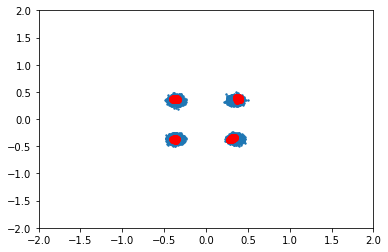

ep:541, D_real_loss: 0.7773, D_fake_loss: 0.5969, D_out_fk: 0.4495,D_out_rl: 0.4507, G_loss: -0.4198, M_loss: 1.2195
g1:-9.822203719522804e-05, g2:-8.430179150309414e-05
ep:542, D_real_loss: 0.7794, D_fake_loss: 0.5979, D_out_fk: 0.4500,D_out_rl: 0.4495, G_loss: -0.5674, M_loss: 1.3659
g1:-6.219849456101656e-05, g2:-2.006443901336752e-05
ep:543, D_real_loss: 0.7765, D_fake_loss: 0.5966, D_out_fk: 0.4493,D_out_rl: 0.4511, G_loss: -0.4100, M_loss: 1.2102
g1:4.766765050590038e-05, g2:1.7617514458834194e-05
ep:544, D_real_loss: 0.7786, D_fake_loss: 0.5963, D_out_fk: 0.4491,D_out_rl: 0.4500, G_loss: -0.6849, M_loss: 1.4856
g1:-1.591891486896202e-05, g2:-3.155017111566849e-05
ep:545, D_real_loss: 0.7806, D_fake_loss: 0.5997, D_out_fk: 0.4510,D_out_rl: 0.4489, G_loss: -0.3910, M_loss: 1.1873
g1:-0.00011525648005772382, g2:-4.608111339621246e-05
ep:546, D_real_loss: 0.7746, D_fake_loss: 0.5939, D_out_fk: 0.4478,D_out_rl: 0.4522, G_loss: -0.6295, M_loss: 1.4330
g1:-0.00027063017478212714, g2:-0

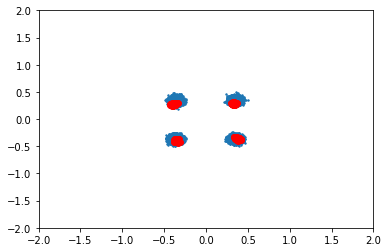

ep:551, D_real_loss: 0.7828, D_fake_loss: 0.6066, D_out_fk: 0.4546,D_out_rl: 0.4479, G_loss: -0.6625, M_loss: 1.4512
g1:-0.00013264843437355012, g2:-0.00011050759349018335
ep:552, D_real_loss: 0.7827, D_fake_loss: 0.6015, D_out_fk: 0.4519,D_out_rl: 0.4478, G_loss: -0.6897, M_loss: 1.4842
g1:0.00010181179823121056, g2:0.00011563848966034129
ep:553, D_real_loss: 0.7790, D_fake_loss: 0.5977, D_out_fk: 0.4497,D_out_rl: 0.4501, G_loss: -0.6025, M_loss: 1.4021
g1:-3.4513337595853955e-05, g2:1.570013955642935e-05
ep:554, D_real_loss: 0.7793, D_fake_loss: 0.5915, D_out_fk: 0.4463,D_out_rl: 0.4499, G_loss: -0.6336, M_loss: 1.4411
g1:-0.00010660658881533891, g2:-0.00014236988499760628


KeyboardInterrupt: 

In [14]:
samples=[] #generator examples

init=tf.global_variables_initializer()

with tf.Session() as sess:
    # sess=tf.Session()
    sess.run(init)


    for epoch in range(10000):

        perm = np.random.permutation(n_samples)

        for i in range(num_batches):

            batch_x    = x[i*batch_size:(i+1)*(batch_size)]
            batch_eps  = np.random.uniform(-1., 1., size=[batch_size,noise_dim])#np.random.randn(batch_size,noise_dim)

            categorical_code = np.random.randint(0,code_dim,size=batch_size)
            batch_code = indices_to_one_hot(categorical_code,code_dim)


            feed_dict = {x_real:batch_x, eps:batch_eps, code:batch_code, is_training:True}

            sess.run(D_train_op,feed_dict)
            sess.run(G_train_op,feed_dict)
            sess.run(M_train_op,feed_dict)
    #         sess.run(M_train_op_m,feed_dict)
    #         sess.run(M_train_op_g,feed_dict)


        D_real,D_fake,D_outF,D_outR,g_loss,m_loss = sess.run([D_real_loss,D_fake_loss,D_out_fake,D_out_real,G_loss,M_loss],\
                                               feed_dict)
        print("ep:{}, D_real_loss: {:0.4f}, D_fake_loss: {:0.4f}, D_out_fk: {:0.4f},D_out_rl: {:0.4f}, G_loss: {:0.4f}, M_loss: {:0.4f}".format(epoch,D_real,D_fake,np.mean(D_outF),np.mean(D_outR),g_loss,-m_loss))

        g1,g2 = sess.run([ggu,ggm],feed_dict)

        print('g1:{}, g2:{}'.format(np.mean(g1[2]),np.mean(g2[2])))


        sample_eps = np.random.uniform(-1,1,size=(200,noise_dim))
        aa = np.random.randint(0,code_dim,size=200)
        sample_cod = indices_to_one_hot(aa,code_dim)

        gen_sample = sess.run(x_tld,feed_dict={eps:sample_eps, code:sample_cod, is_training:True})

        if epoch%10 == 0:
            plt.scatter(x[:,0], x[:,1], s=2.0)
            plt.scatter(gen_sample[:,0],gen_sample[:,1],c='r')
            plt.xlim((-2, 2))
            plt.ylim((-2, 2))
            plt.show()

            #samples.append(gen_sample)

In [ ]:

    
sample_eps = np.random.uniform(-1,1,size=(200,noise_dim))
aa = 3*np.ones(200, dtype=int)#np.random.randint(0,code_dim,size=200)
sample_cod = indices_to_one_hot(aa,code_dim)

gen_sample = sess.run(x_tld,feed_dict={eps:sample_eps, code:sample_cod, is_training:True})


plt.scatter(x[:,0], x[:,1], s=2.0)
plt.scatter(gen_sample[:,0],gen_sample[:,1],c='r')
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.show()

In [ ]:
aa